# <a id='toc1_'></a>[Amazon Software Products Recommender System](#toc0_)

>  we build several types of recommender systems, including a hybrid model to generate recommendations for software products for customers on amazon.

**Table of contents**<a id='toc0_'></a>    
- [Overview](#toc2_)    
  - [Data](#toc2_1_)    
  - [Model Evaluations and Metrics](#toc2_2_)    
- [Setup and Data Loading](#toc3_)    
- [Data Exploration](#toc4_)    
- [Data Cleaning](#toc5_)    
- [Sentiment Analysis](#toc6_)    
    - [Sentiment Lexicons](#toc6_1_1_)    
    - [Review text by Customers](#toc6_1_2_)    
    - [Tokenization](#toc6_1_3_)    
- [Collaborative Filtering](#toc7_)    
  - [Non-negative Matrix Factorisation](#toc7_1_)    
  - [Deep Matrix Factorisation](#toc7_2_)    
  - [Neural Collaborative Filtering](#toc7_3_)    
- [Content Based Filtering](#toc8_)    
  - [Using Review Text, Titles and Brand](#toc8_1_)    
- [Hybrid Recommender Model](#toc9_)    
  - [Content Based & Collaborative Filtering](#toc9_1_)    
- [Results and Conclusion](#toc10_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Overview](#toc0_)

In this project, we work with an amazon dataset which has product review information with over 12 000 reviews across over 800 software products on Amazon. THe goal of the project is develop three different types of recommender systems - collaborative filtering system, content based filtering system and a hybrid recommender system. Within each of these types of recommenders we may build one or more models. We also perform sentiment analysis to assess the emotion or feeling around a user's review. 

***We also consider using sentiment analysis to generate possible features to include in our recommender models***.


## <a id='toc2_1_'></a>[Data](#toc0_)

We use an **amazon product review dataset** made available in 2018. The dataset is an updated version of the ***Amazon review dataset*** released in 2014. As in the previous version, this dataset includes **reviews** (ratings, text, helpfulness votes), product **metadata** (descriptions, category information, price, brand, and image features). We shall make use of a smaller subset of the original data. Specifically, we have the amazon product review dataset for software products only! For more information look at the dataset [homepage](https://nijianmo.github.io/amazon/index.html). 

    The dataset has over 12 000 customer reviews and has over 800 software products sold on Amazon.


## <a id='toc2_2_'></a>[Model Evaluations and Metrics](#toc0_)

There are a variety of metrics we can use to assess our models. Some of which are given below (which we shall use):

- ***Root Mean Squared Error (RMSE)***: This is a common metric used in collaborative filtering to evaluate the accuracy of the predicted ratings. You can calculate the RMSE by comparing the predicted ratings to the actual ratings in the dataset.

- ***Coverage***: This metric measures the percentage of unique items that are recommended to at least one user. A higher coverage indicates that the recommender system is able to recommend a wider variety of items to users.

- ***Diversity***: This metric measures the diversity of the recommendations, and is used to ensure that the recommender system is not always recommending the same set of items to all users. A higher diversity indicates that the recommender system is able to recommend a wider variety of items to different users.


# <a id='toc3_'></a>[Setup and Data Loading](#toc0_)

We begin by loading the packages for this project. We then load the datasets with our product reviews and product metadata. We then seek to merge them. 

In [1]:
# get modules 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [2]:
# read in data
soft_data = pd.read_json('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/My Github/Recommender-Systems/Data/Amazon Data/Software_5.json',lines=True)

# view data
display(soft_data.head(3))
print("shape of Data:", soft_data.shape)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"10 20, 2010",A38NELQT98S4H8,0321719816,{'Format:': ' DVD-ROM'},WB Halper,I've been using Dreamweaver (and it's predeces...,A solid overview of Dreamweaver CS5,1287532800,NaN,NaN
1,4,False,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,{'Format:': ' DVD-ROM'},Grimmy,"The demo is done with the PC version, with ref...",A good value,1287360000,NaN,NaN
2,5,False,"10 16, 2010",ACJT8MUC0LRF0,0321719816,{'Format:': ' DVD-ROM'},D. Fowler,If you've been wanting to learn how to create ...,This is excellent software for those who want ...,1287187200,3,NaN


shape of Data: (12805, 12)


By setting `lines=True`, `pandas.read_json()` reads the JSON file line by line, treating each line as a separate JSON object. This is useful when you have a file that contains multiple JSON objects, each on a separate line, as is often the case with log files or other data sources that generate JSON data.



In [3]:
# structure
soft_data.dtypes

# trim data 
soft_data = soft_data[[ 'reviewerID', 'reviewerName', 'asin', 'reviewText', 'overall']]

# see new data
soft_data.head(3)

,reviewerID,reviewerName,asin,reviewText,overall
0,A38NELQT98S4H8,WB Halper,0321719816,I've been using Dreamweaver (and it's predeces...,4
1,A3QJU4FEN8PQSZ,Grimmy,0321719816,"The demo is done with the PC version, with ref...",4
2,ACJT8MUC0LRF0,D. Fowler,0321719816,If you've been wanting to learn how to create ...,5


In [4]:
# read in metadata
meta = pd.read_json('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/My Github/Recommender-Systems/Data/Amazon Data/meta_Software.json',lines=True)

# remove irrelevant columns
meta = meta[['asin', 'title', 'description', 'brand', 'price']]
meta.head(2)

,asin,title,description,brand,price
0,0030672120,HOLT PHYSICS LESSON PRESENTATION CD-ROM QUICK ...,[],HOLT. RINEHART AND WINSTON,.a-box-inner{background-color:#fff}#alohaBuyBo...
1,0071480935,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)...","[, <b>Latin rhythms that will get your kids si...",McGraw Hill,


In [5]:
# merge the data
soft_data = pd.merge(soft_data, meta[['asin', 'title', 'description', 'brand']], on='asin')

# view merged dataframe
soft_data.head(3)

,reviewerID,reviewerName,asin,reviewText,overall,title,description,brand
0,A38NELQT98S4H8,WB Halper,0321719816,I've been using Dreamweaver (and it's predeces...,4,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
1,A3QJU4FEN8PQSZ,Grimmy,0321719816,"The demo is done with the PC version, with ref...",4,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press
2,ACJT8MUC0LRF0,D. Fowler,0321719816,If you've been wanting to learn how to create ...,5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,[This complete training program from Adobe Pre...,Peach Pit Press


***
# <a id='toc4_'></a>[Data Exploration](#toc0_)

In [6]:
# descriptive statistics for ratings
soft_data['overall'].describe()

count    14103.00000
mean         3.94214
std          1.35304
min          1.00000
25%          3.00000
50%          4.00000
75%          5.00000
max          5.00000
Name: overall, dtype: float64

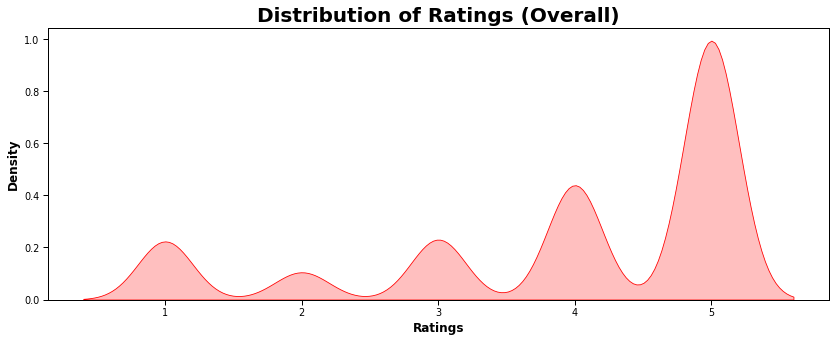

In [7]:
fig = plt.figure(figsize=(14,5))
sns.set_context("paper",font_scale=1.1)

ax = sns.kdeplot(soft_data['overall'],
                 color="Red", shade = True)
ax.set_ylabel('Density', fontsize=12, fontweight='bold')
ax.set_xlabel('Ratings', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Ratings (Overall)', fontsize=20, fontweight='bold');

In [8]:
# How many customers
print("Number of Customers:", soft_data.reviewerID.unique().size)

# Count Reviews and Average Rating per Customer
cust_data = soft_data.groupby(['reviewerID']).agg({"overall": ["count", "mean"]})
cust_data.columns = ['count_rev', 'mean_rat']
cust_data['mean_rat'] = np.round(cust_data.mean_rat,3)
display(cust_data.head(4))

Number of Customers: 1826


,count_rev,mean_rat
reviewerID,,
A100UD67AHFODS,5,4.80
A105S56ODHGJEK,29,3.69
A1075X1Q4M3S78,5,5.00
A10C5CJK1YKGV0,10,4.10


Text(0.5, 1.0, 'Average Ratings by Number of Reviews')

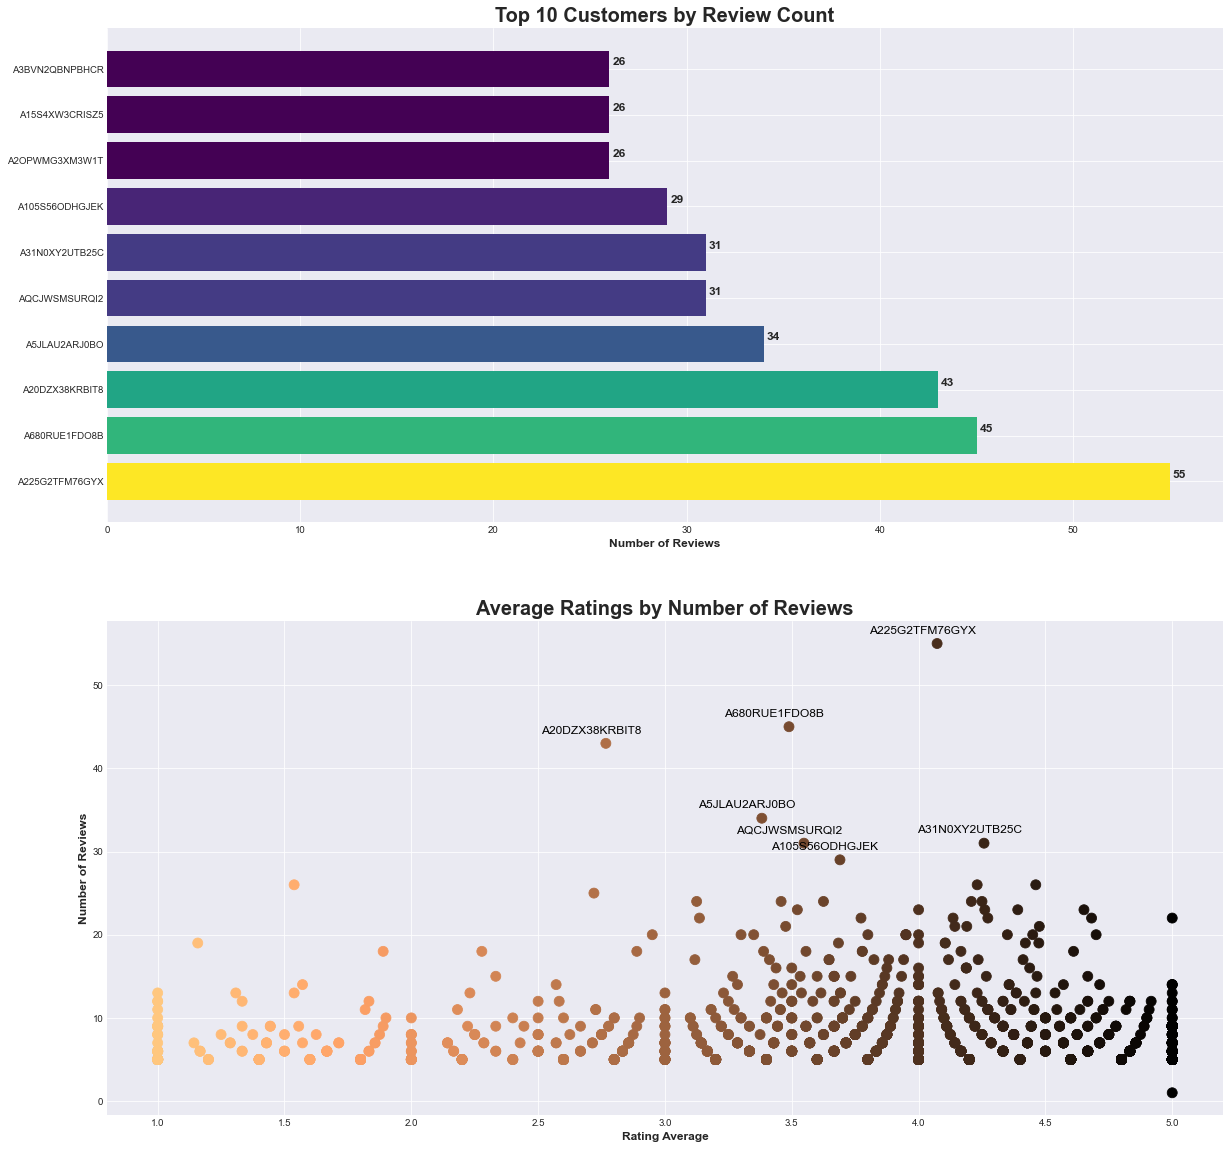

In [9]:
# Plot of Most - bar plot
plt.style.use('seaborn-darkgrid')
sample_top = cust_data.sort_values(['count_rev'], ascending=False).head(10)
count_min = sample_top.count_rev.min() # get range
count_max = sample_top.count_rev.max()
count_norm = (sample_top.count_rev - count_min) / (count_max - count_min) # Normalize 
colors = cm.viridis(count_norm) # Use a colormap to map vote average


fig = plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
bar = plt.barh(y=sample_top.index, width=sample_top.count_rev, color=colors)
plt.title("Top 10 Customers by Review Count", fontsize=20, fontweight='bold')
plt.xlabel("Number of Reviews", fontsize=12, fontweight='semibold')
plt.ylabel("", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 25), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)

# Plot of Average Rating vs Count Reviews - scatter plot
plt.subplot(2, 1, 2)
plt.scatter(cust_data.mean_rat, cust_data.count_rev, c=cust_data.mean_rat, cmap='copper_r', s=100)
plt.xlabel('Rating Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Reviews', fontsize=12, fontweight='semibold')
for i, id in enumerate(cust_data.index):
    if (cust_data.count_rev[i] > 26):
        plt.annotate(id, (cust_data.loc[cust_data.index==id, "mean_rat"], cust_data.loc[cust_data.index==id, "count_rev"]), textcoords="offset points", xytext=(-15,10), ha='center', fontsize=12, color='black')
    else: continue
plt.title("Average Ratings by Number of Reviews", fontsize=20, fontweight='bold')


In [10]:
# How many items/products?
print("Number of Products:", soft_data.asin.unique().size)

# Number reviews and average ratings per product
prod_data = soft_data.groupby(['asin']).agg({"overall": ["count", "mean"]})
prod_data.columns = ['count_rev', 'mean_rat']
prod_data['mean_rat'] = np.round(prod_data.mean_rat,3)
display(prod_data.head(4))

Number of Products: 802


,count_rev,mean_rat
asin,,
0321700945,8,4.750
0321719816,14,4.571
0321719824,9,4.222
0763855553,36,4.028


Text(0.5, 1.0, 'Average Ratings by Number of Reviews')

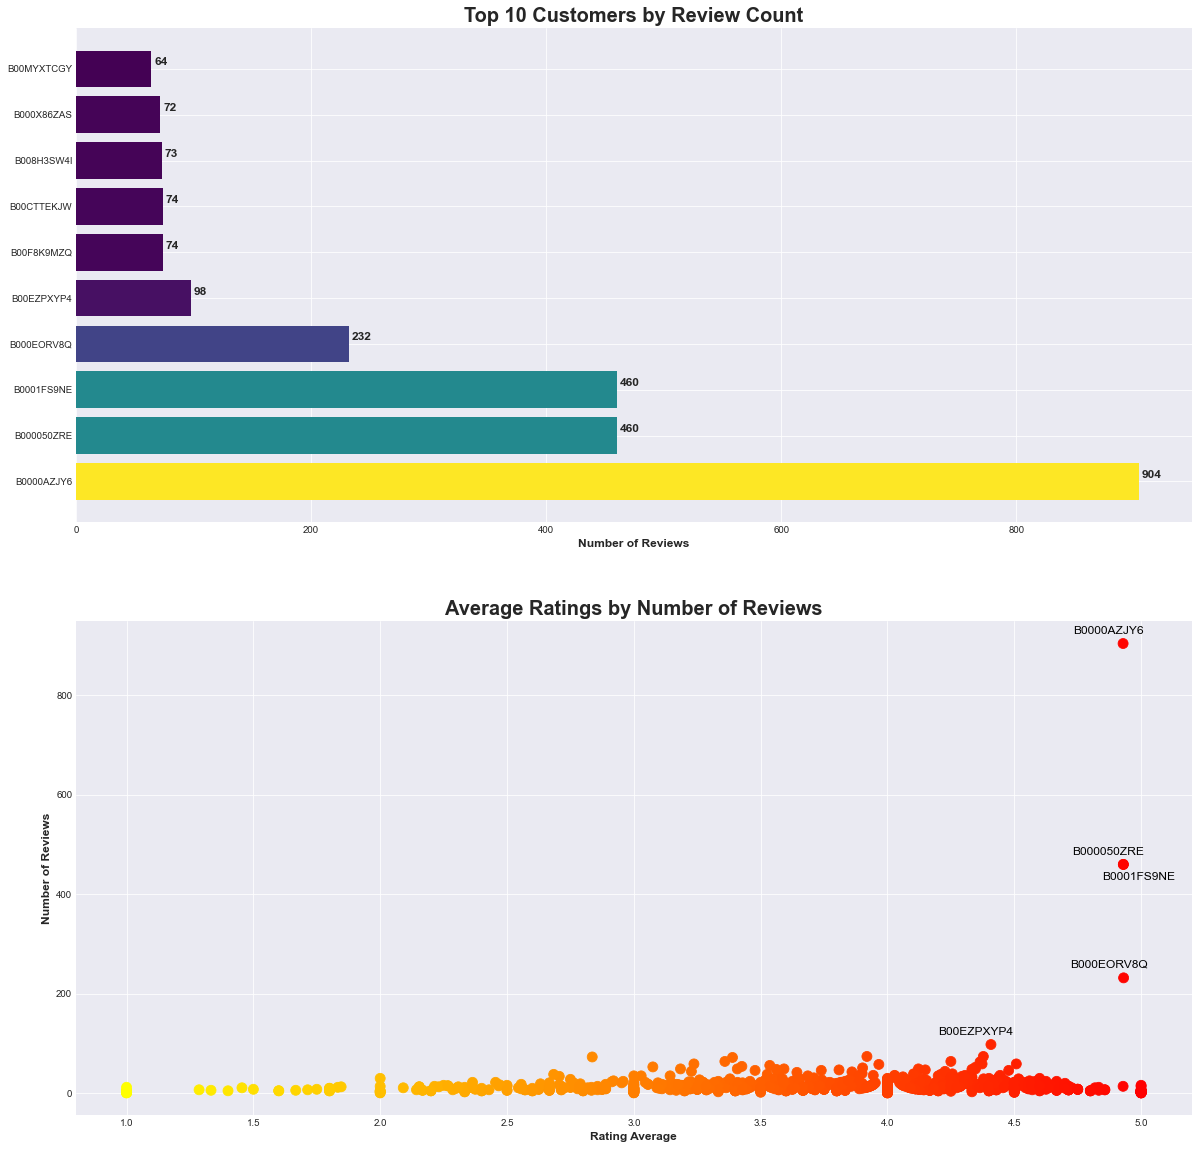

In [11]:
# Plot of Most / Fewest Reviews 
plt.style.use('seaborn-darkgrid')
sample_top = prod_data.sort_values(['count_rev'], ascending=False).head(10)
count_min = sample_top.count_rev.min() # get range
count_max = sample_top.count_rev.max()
count_norm = (sample_top.count_rev - count_min) / (count_max - count_min) # Normalize 
colors = cm.viridis(count_norm) # Use a colormap to map vote average

fig = plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
bar = plt.barh(y=sample_top.index, width=sample_top.count_rev, color=colors)
plt.title("Top 10 Customers by Review Count", fontsize=20, fontweight='bold')
plt.xlabel("Number of Reviews", fontsize=12, fontweight='semibold')
plt.ylabel("", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 25), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)

# Plot of Average Rating vs Count Reviews
plt.subplot(2, 1, 2)
plt.scatter(prod_data.mean_rat, prod_data.count_rev, c=prod_data.mean_rat, cmap='autumn_r', s=100)
plt.xlabel('Rating Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Reviews', fontsize=12, fontweight='semibold')
for i, id in enumerate(prod_data.index):
    if (prod_data.count_rev[i] >= 98):
        if id == 'B0001FS9NE':
            xytext = (15, -15)
        else: xytext=(-15,10)
        plt.annotate(id, (prod_data.loc[prod_data.index==id, "mean_rat"], prod_data.loc[prod_data.index==id, "count_rev"]), textcoords="offset points",xytext=xytext, ha='center', fontsize=12, color='black')
    else: continue
plt.title("Average Ratings by Number of Reviews", fontsize=20, fontweight='bold')

***
# <a id='toc5_'></a>[Data Cleaning](#toc0_)

We are to clean our text features in our dataset, so as to prepare it for further analysis. This includes removing all punctuation marks, whitespace, make all text lowercase, and remove stop words as well as numbers if irrelevant. Specifically, we are interested in cleaning the following columns or features:

- ***reviewText***
- ***title***
- ***description***


More so we are interested in seeing if there is any **missing data** in the columns of interest and decide if imputation is necessary. Also we want to ensure the **data types** are correct for all the features. Finally, we want to ensure there are no **duplicated data**. 


 There are missing values in the data.


,reviewerID,reviewerName,asin,reviewText,overall,title,description,brand
5279,A1VQHH85U7PX0,NaN,B001EHXOFG,"Nowadays, I have grown to be very dependant on...",4,Microsoft Streets &amp; Trips 2009 [OLD VERSION],[NEW&#8212;Entertainment online&#8217;s FREE t...,Microsoft
5503,A1VQHH85U7PX0,NaN,B001TYYZCA,I used Corel Painter X before upgrading to Cor...,3,Corel Painter 11 [OLD VERSION],[Corel Painter 11 is the ultimate art studio f...,Corel
6012,A1VQHH85U7PX0,NaN,B002JB3CUS,PaperPort is a very helpful tool for reducing ...,4,"PaperPort 12 [Old Version]"" />",[Overwhelmed by paperwork? Feeling disorganize...,Nuance Dragon
6210,A1VQHH85U7PX0,NaN,B0039Y58YC,WordPerect X5 is an office suite consisting of...,5,WordPerfect Office X5 Standard [Old Version],"[Create great-looking documents, spreadsheets ...",Corel
9232,A1VQHH85U7PX0,NaN,B00CTTEKJW,I finally caved to Amazon's relentless efforts...,4,Amazon Music [PC] [Download],"[<table border=""0"" cellpadding=""5"" cellspacing...",Amazon Digital Services LLC



 Columns with Missing Data:
 reviewerID      0
reviewerName    9
asin            0
reviewText      1
overall         0
title           0
description     0
brand           0
dtype: int64


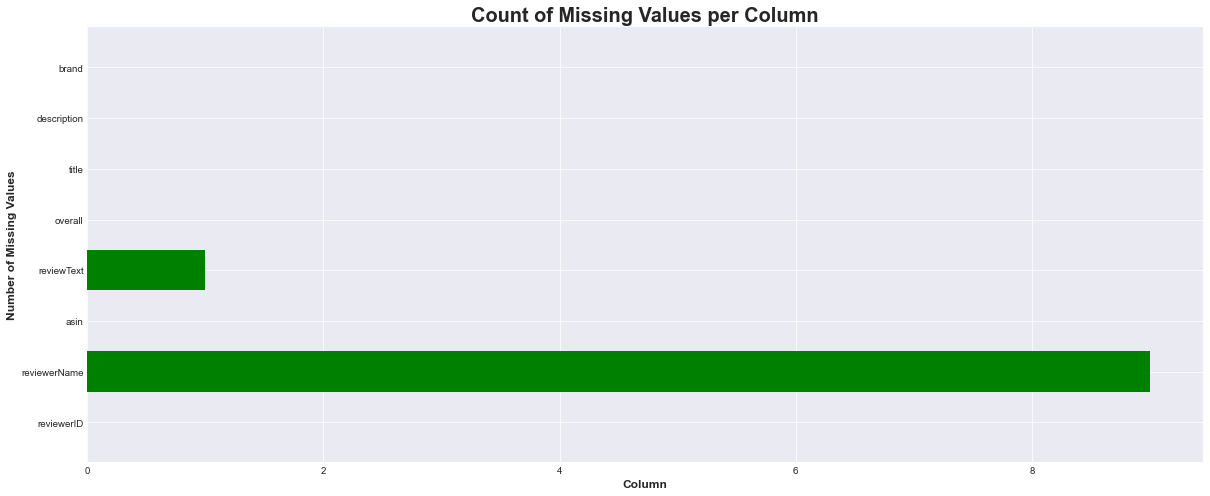

In [12]:
# check if any of the columns have missing values
is_na = soft_data.isna().any().any()

# if there are NA values in columns -> show rows, show number of NAs per column
if is_na:
    print("\n There are missing values in the data.")
    display(soft_data[soft_data.isna().any(axis=1)].head(5))
    print("\n Columns with Missing Data:\n", soft_data.isna().sum())
    missing_values_count = soft_data.isna().sum()
    plt.style.use('seaborn-darkgrid')
    fig = plt.figure(figsize=(20, 8))
    plt.barh(y=missing_values_count.index, width=missing_values_count.values, color="green")
    plt.xlabel("Column", fontsize=12, fontweight='semibold')
    plt.ylabel("Number of Missing Values", fontsize=12, fontweight='semibold')
    plt.title("Count of Missing Values per Column", fontsize=20, fontweight='bold')
    plt.show()

else:
    print("There are no missing values in the data.")

In [13]:
# remove rows with missing values for reviewerName
remove_ind = soft_data.loc[soft_data.isna().any(axis=1), 'reviewerName'].index
soft_data.drop(remove_ind, inplace=True)

# fill in missing values
soft_data.loc[soft_data.isna().any(axis=1), "reviewText"] = ""

# check for missing data
is_na = soft_data.isna().any().any()
if is_na: print("\n There are missing values in the data.")
else: print("There are no missing values in the data.")

There are no missing values in the data.


In [14]:
# make sure columns are text (strings)
soft_data['reviewText'] = soft_data['reviewText'].astype(str)
soft_data['title'] = soft_data['title'].astype(str)
soft_data['description'] = soft_data['description'].astype(str)
soft_data['brand'] = soft_data['brand'].astype(str)

# replace [] with title column
soft_data['description'] = soft_data['description'].str.replace(r'\[\]', '', regex=True)
mask = soft_data['description'] == ''
soft_data.loc[mask, 'description'] = soft_data.loc[mask, 'title'].fillna('')

In [15]:
# find any duplicate rows
soft_data.duplicated().any()

# show duplicate rows
soft_data[soft_data.duplicated()]

# remove duplicate rows
soft_data.drop_duplicates(inplace=True)

In [16]:
# load packages
import re

# function to clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Clean text data
soft_data['new_review'] = soft_data['reviewText'].apply(clean_text)
soft_data['new_title'] = soft_data['title'].apply(clean_text)
soft_data['new_desc'] = soft_data['description'].apply(clean_text)
soft_data['new_brand'] = soft_data['brand'].apply(clean_text)
soft_data.head(3)[['new_review', 'new_title', 'new_desc', 'new_brand']]

,new_review,new_title,new_desc,new_brand
0,i ve been using dreamweaver and it s predecess...,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press
1,the demo is done with the pc version with refe...,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press
2,if you ve been wanting to learn how to create ...,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press


The code defines a function called `clean_text` that takes in a string `text` as input and returns the cleaned version of the string.

Here's a breakdown of what each line of the function does:

1. `text = text.lower()`: This line converts all uppercase characters in the string to lowercase. This step is usually performed in natural language processing to ensure that uppercase and lowercase versions of the same word are treated as the same.

2. `text = re.sub(r'[^a-zA-Z0-9]', ' ', text)`: This line uses the `re` module (short for regular expressions) to substitute any non-alphanumeric characters in the string with a space. The regular expression `[^a-zA-Z0-9]` matches any character that is not a letter or a number.

3. `text = re.sub(r'\s+', ' ', text)`: This line uses the re module to replace any sequences of one or more whitespace characters (such as spaces or tabs) with a single space.

4. `text = text.strip()`: This line removes any leading or trailing whitespace from the string.

5. `return text`: This line returns the cleaned version of the string.

Overall, this function is useful for cleaning up unstructured text data by removing non-alphanumeric characters and normalizing the case of the text. It can be used as a preprocessing step before performing tasks like sentiment analysis, topic modeling, or text classification.

***
# <a id='toc6_'></a>[Sentiment Analysis](#toc0_)

Sentiment analysis is the study of the emotional content of a body of text. 

- We shall look briefly at sentiment lexicons. 
- We shall then aggregating sentiments over words to assess sentiments of longer texts. 
- We shall also look at handling “negation” words like “not” that affect sentiment

### <a id='toc6_1_1_'></a>[Sentiment Lexicons](#toc0_)

One way of approaching the problem is to **assess the sentiment of individual words**, and then aggregate the sentiments of the words in a body of text in some way. For example, if we can classify whether each word is positive, negative, or neutral, we can count up the number of positive, negative, and neutral words in the document and define that as the sentiment of the document. This is just one way - a particularly simple way - of doing document-level sentiment analysis.

When assessing the sentiment or emotional content of individual words, we usually make use of **existing sentiment dictionaries (or “lexicons”)** that have already done this using some kind of manual classification.

> The gist is that we are dealing with a specific, pre-defined vocabulary.

> The goal is usually to assign a sentiment score to a text, possibly an overall score, or a generally positive or negative grade

***TLDR; Lexicons are dictionaries or lists that contain words with their corresponding positive or negative polarity scores***

We shall use three different lexicons:

1. **Bing**: a list of English words with their corresponding positive and negative polarity scores. The scores range from -5 (most negative) to 5 (most positive), with 0 indicating neutral sentiment.
2. **NRC**: a lexicon of English words with their corresponding scores on eight different emotions: anger, fear, anticipation, trust, surprise, sadness, joy, and disgust.
3. **AFINN**: a list of English words with their corresponding positive and negative polarity scores. The scores range from -5 (most negative) to 5 (most positive), with 0 indicating neutral sentiment.


In [17]:
# read lexicons in
afinn = pd.read_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/My Github/Recommender-Systems/Data/Lexicons/Afinn.csv')
bing = pd.read_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/My Github/Recommender-Systems/Data/Lexicons/Bing.csv')
nrc = pd.read_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/My Github/Recommender-Systems/Data/Lexicons/NRC.csv')

# AFINN
print("Shape of AFINN:", afinn.shape)
print("Unique Sentiments:", afinn.value.unique())
display(afinn.head(5))

# BING
print("Shape of Bing:", bing.shape)
print("Unique Sentiments:", bing.sentiment.unique())
display(bing.head(5))

# NRC
print("Shape of NRC:", nrc.shape)
print("Unique Sentiments:", nrc.sentiment.unique())
display(nrc.head(5))


Shape of AFINN: (2477, 2)
Unique Sentiments: [-2 -3  2  1 -1  3  4 -4 -5  5  0]


,word,value
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


Shape of Bing: (6786, 2)
Unique Sentiments: ['negative' 'positive']


,word,sentiment
0,faces,negative
1,abnormal,negative
2,abolish,negative
3,abominable,negative
4,abominably,negative


Shape of NRC: (13901, 2)
Unique Sentiments: ['trust' 'fear' 'negative' 'sadness' 'anger' 'surprise' 'positive'
 'disgust' 'joy' 'anticipation']


,word,sentiment
0,abacus,trust
1,abandon,fear
2,abandon,negative
3,abandon,sadness
4,abandoned,anger


### <a id='toc6_1_2_'></a>[Review text by Customers](#toc0_)

We look at the text of the reviews as a whole and calculate the sentiments for each review. This is done by using sentiment lexicons and breaking each review up into its constituent words and attaching a sentiment score to each word. We then sum of the sentiment scores for each word in a review and get the total sentiment for that review. This is done for all reviews. 

In [18]:
# Load AFINN
from afinn import Afinn

# Load the AFINN dictionary
afinn = Afinn()

# Define a function to calculate the sentiment score of each review
def get_sentiment_afinn(review):
    # Split the review into words
    words = review.split()
    # Calculate the sentiment score of each word using AFINN and sum the scores
    sentiment_score = sum(afinn.score(word) for word in words)
    return sentiment_score

# Apply the function to the 'review' column of your DataFrame
soft_data['sentiment_afinn'] = soft_data['new_review'].apply(get_sentiment_afinn)
soft_data[['new_review', 'sentiment_afinn']].head(4)

,new_review,sentiment_afinn
0,i ve been using dreamweaver and it s predecess...,17.0
1,the demo is done with the pc version with refe...,12.0
2,if you ve been wanting to learn how to create ...,47.0
3,i ve been creating websites with dreamweaver f...,26.0


The command `afinn.score(word)` returns the sentiment score of the word based on the **AFINN** dictionary. The sentiment score of each review is calculated by summing the sentiment scores of all the words in the review. The resulting sentiment scores are stored in a new `'sentiment_afinn'` column of the DataFrame.

In [22]:
# load packages for BING
from textblob import TextBlob
from textblob.sentiments import PatternAnalyzer

# function to calculate sentiment using bing
def get_sentiment_bing(text):
    sentiment = 0
    blob = TextBlob(text, analyzer=PatternAnalyzer())
    for sentence in blob.sentences:
        for word in sentence.words:
            polarity = TextBlob(word, analyzer=PatternAnalyzer()).sentiment.polarity
            if polarity > 0:
                sentiment += 1
            elif polarity < 0:
                sentiment -= 1
    return sentiment

# run function on reviews
soft_data['sentiment_bing'] = soft_data['new_review'].apply(get_sentiment_bing)
soft_data[['new_review', 'sentiment_bing']].head(3)

,new_review,sentiment_bing
0,i ve been using dreamweaver and it s predecess...,11
1,the demo is done with the pc version with refe...,-6
2,if you ve been wanting to learn how to create ...,24


> does sentiment analysis for all reviews using the Bing lexicon

This code defines a function `get_sentiment_bing()` that takes a text as input and returns its sentiment using the Bing lexicon. The function first creates a `TextBlob` object with the `PatternAnalyzer()` as the analyzer. It then iterates through each word in each sentence of the text, and uses the `TextBlob` object to get the polarity of each word. If the polarity is positive, the sentiment value is incremented by 1, and if it's negative, the sentiment value is decremented by 1. Finally, the function returns the sentiment value.

The last line of the code applies this function to the `'new_review'` column of the `'soft_data'` dataframe, and stores the sentiment value in a column. This will give you a new dataframe with a sentiment score for each review.

In [23]:
# Number reviews and sentiment per customer
cust_data = soft_data.groupby(['reviewerID']).agg({"sentiment_afinn": ["count", "mean"], "sentiment_bing": ["mean"]})
cust_data.columns = ['count_rev', 'mean_sent_afinn', 'mean_sent_bing']
cust_data = np.round(cust_data, 2)

# Number reviews and sentiment per product
prod_data = soft_data.groupby(['asin']).agg({"sentiment_afinn": ["count", "mean"], "sentiment_bing": ["mean"]})
prod_data.columns = ['count_rev', 'mean_sent_afinn', 'mean_sent_bing']
prod_data = np.round(prod_data, 2)

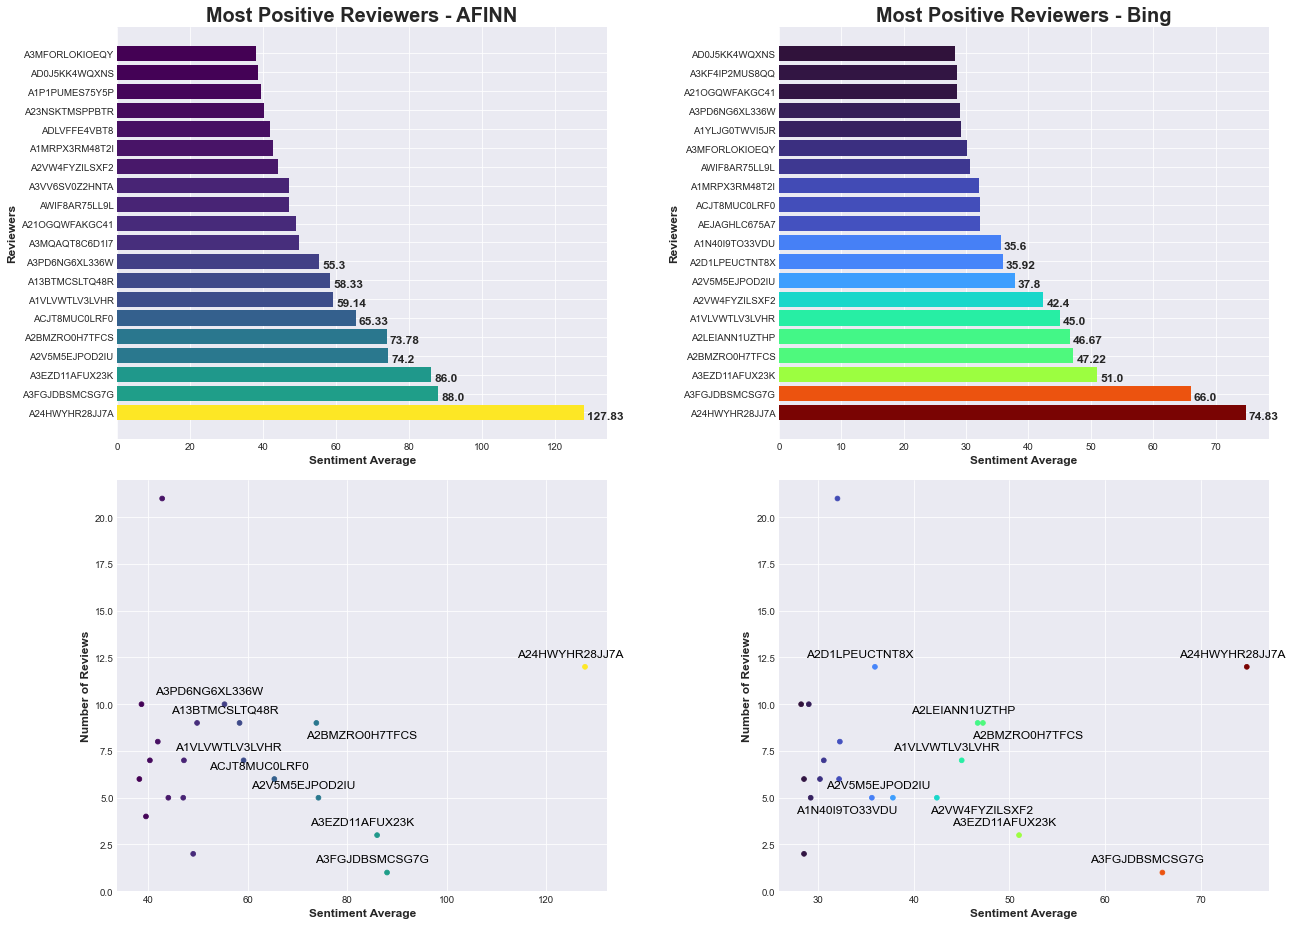

In [30]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(20, 15))


# Most Positive - AFINN
cust_data1 = cust_data.sort_values(['mean_sent_afinn'], ascending=False)
cust_data1 = cust_data1.head(20)
sent_min = cust_data1.mean_sent_afinn.min() 
sent_max = cust_data1.mean_sent_afinn.max()
sent_norm = (cust_data1.mean_sent_afinn - sent_min) / (sent_max - sent_min) 
colors_afinn = cm.viridis(sent_norm) 

plt.subplot(2, 2, 1)
bar = plt.barh(y=cust_data1.index, width=cust_data1.mean_sent_afinn, color=colors_afinn)
plt.title("Most Positive Reviewers - AFINN", fontsize=20, fontweight='bold')
plt.xlabel("Sentiment Average", fontsize=12, fontweight='semibold')
plt.ylabel("Reviewers", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    if height > 50:
        plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 4), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)
    else: continue


plt.subplot(2, 2, 3)
plt.scatter(cust_data1.mean_sent_afinn, cust_data1.count_rev, c=colors_afinn, cmap='viridis')
plt.xlabel('Sentiment Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Reviews', fontsize=12, fontweight='semibold')
for i, id in enumerate(cust_data1.index):
    if cust_data1.mean_sent_afinn[i] > 50:
        if id == "A2BMZRO0H7TFCS":
            plt.annotate(id, (cust_data1.loc[cust_data1.index==id, "mean_sent_afinn"], cust_data1.loc[cust_data1.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(45,-15), ha='center', fontsize=12, color='black')
        else: 
            plt.annotate(id, (cust_data1.loc[cust_data1.index==id, "mean_sent_afinn"], cust_data1.loc[cust_data1.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(-15,10), ha='center', fontsize=12, color='black')

    else: continue

# Most Positive - BING
cust_data1 = cust_data.sort_values(['mean_sent_bing'], ascending=False).head(20)
sent_min = cust_data1.mean_sent_bing.min()
sent_max = cust_data1.mean_sent_bing.max()
sent_norm = (cust_data1.mean_sent_bing - sent_min) / (sent_max - sent_min) 
colors_bing = cm.turbo(sent_norm) 

plt.subplot(2, 2, 2)
bar = plt.barh(y=cust_data1.index, width=cust_data1.mean_sent_bing, color=colors_bing)
plt.title("Most Positive Reviewers - Bing", fontsize=20, fontweight='bold')
plt.xlabel("Sentiment Average", fontsize=12, fontweight='semibold')
plt.ylabel("Reviewers", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    if height > 35:
        plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 4), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)
    else: continue


plt.subplot(2, 2, 4)
plt.scatter(cust_data1.mean_sent_bing, cust_data1.count_rev, c=colors_bing, cmap='turbo')
plt.xlabel('Sentiment Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Reviews', fontsize=12, fontweight='semibold')
for i, id in enumerate(cust_data1.index):
    if cust_data1.mean_sent_bing[i] > 35:
        if (id == "A2BMZRO0H7TFCS") or (id == "A2VW4FYZILSXF2"):
            plt.annotate(id, (cust_data1.loc[cust_data1.index==id, "mean_sent_bing"], cust_data1.loc[cust_data1.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(45,-15), ha='center', fontsize=12, color='black')
        elif (id == "A1N40I9TO33VDU"):
            plt.annotate(id, (cust_data1.loc[cust_data1.index==id, "mean_sent_bing"], cust_data1.loc[cust_data1.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(-25,-15), ha='center', fontsize=12, color='black')
        else: 
            plt.annotate(id, (cust_data1.loc[cust_data1.index==id, "mean_sent_bing"], cust_data1.loc[cust_data1.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(-15,10), ha='center', fontsize=12, color='black')
    else: continue
    

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.35, hspace=0.1)


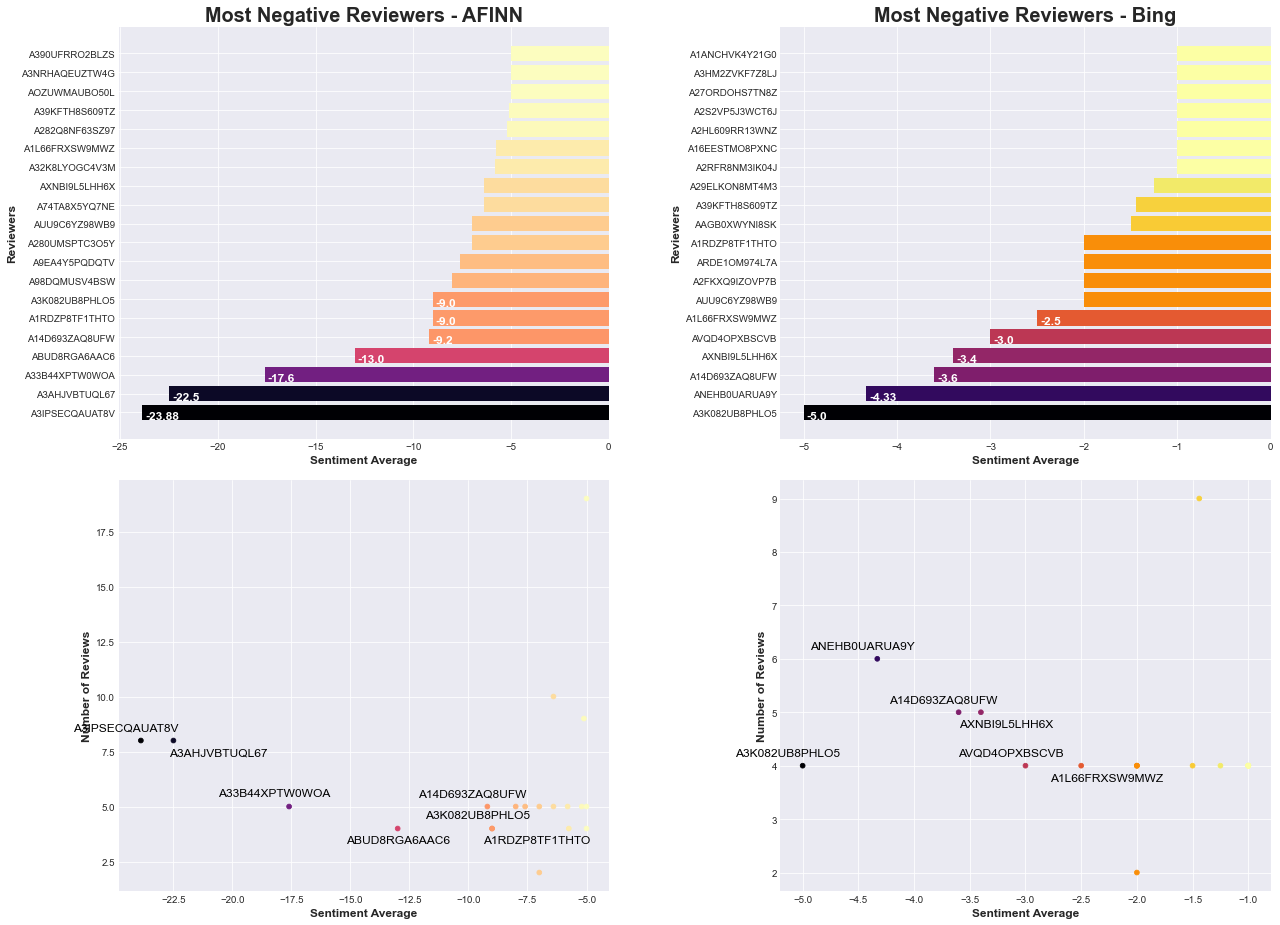

In [32]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(20, 15))


# Most Negative - AFINN
cust_data2 = cust_data.sort_values(['mean_sent_afinn'], ascending=True)
cust_data2 = cust_data2.head(20)
sent_min = cust_data2.mean_sent_afinn.min() 
sent_max = cust_data2.mean_sent_afinn.max()
sent_norm = (cust_data2.mean_sent_afinn - sent_min) / (sent_max - sent_min) 
colors_afinn = cm.magma(sent_norm) 

plt.subplot(2, 2, 1)
bar = plt.barh(y=cust_data2.index, width=cust_data2.mean_sent_afinn, color=colors_afinn)
plt.title("Most Negative Reviewers - AFINN", fontsize=20, fontweight='bold')
plt.xlabel("Sentiment Average", fontsize=12, fontweight='semibold')
plt.ylabel("Reviewers", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    if height < -8:
        plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 4), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12, 
                color = 'white')
    else: continue


plt.subplot(2, 2, 3)
plt.scatter(cust_data2.mean_sent_afinn, cust_data2.count_rev, c=colors_afinn, cmap='magma')
plt.xlabel('Sentiment Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Reviews', fontsize=12, fontweight='semibold')
for i, id in enumerate(cust_data2.index):
    if cust_data2.mean_sent_afinn[i] < -8:
        if (id == "A3AHJVBTUQL67") or (id == "A1RDZP8TF1THTO") :
            plt.annotate(id, (cust_data2.loc[cust_data2.index==id, "mean_sent_afinn"], cust_data2.loc[cust_data2.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(45,-15), ha='center', fontsize=12, color='black')
        elif (id == "ABUD8RGA6AAC6"):
            plt.annotate(id, (cust_data2.loc[cust_data2.index==id, "mean_sent_afinn"], cust_data2.loc[cust_data2.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(0,-15), ha='center', fontsize=12, color='black')
        else: 
            plt.annotate(id, (cust_data2.loc[cust_data2.index==id, "mean_sent_afinn"], cust_data2.loc[cust_data2.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(-15,10), ha='center', fontsize=12, color='black')

    else: continue

# Most Negative - BING
cust_data2 = cust_data.sort_values(['mean_sent_bing'], ascending=True)
cust_data2 = cust_data2.head(20)
sent_min = cust_data2.mean_sent_bing.min()
sent_max = cust_data2.mean_sent_bing.max()
sent_norm = (cust_data2.mean_sent_bing - sent_min) / (sent_max - sent_min) 
colors_bing = cm.inferno(sent_norm) 

plt.subplot(2, 2, 2)
bar = plt.barh(y=cust_data2.index, width=cust_data2.mean_sent_bing, color=colors_bing)
plt.title("Most Negative Reviewers - Bing", fontsize=20, fontweight='bold')
plt.xlabel("Sentiment Average", fontsize=12, fontweight='semibold')
plt.ylabel("Reviewers", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    if height < -2:
        plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 4), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12, 
                color = 'white')
    else: continue


plt.subplot(2, 2, 4)
plt.scatter(cust_data2.mean_sent_bing, cust_data2.count_rev, c=colors_bing, cmap='inferno')
plt.xlabel('Sentiment Average', fontsize=12, fontweight='semibold')
plt.ylabel('Number of Reviews', fontsize=12, fontweight='semibold')
for i, id in enumerate(cust_data2.index):
    if cust_data2.mean_sent_bing[i] < -2:
        if (id == "AXNBI9L5LHH6X") or (id == "A1L66FRXSW9MWZ"):
            plt.annotate(id, (cust_data2.loc[cust_data2.index==id, "mean_sent_bing"], cust_data2.loc[cust_data2.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(25,-15), ha='center', fontsize=12, color='black')
        else: 
            plt.annotate(id, (cust_data2.loc[cust_data2.index==id, "mean_sent_bing"], cust_data2.loc[cust_data2.index==id, "count_rev"]),
                 textcoords="offset points",
                 xytext=(-15,10), ha='center', fontsize=12, color='black')
    else: continue
    

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.35, hspace=0.1)


In [36]:
# Number reviews and sentiment per product - more than 20 reviews per product
prod_data = soft_data.groupby(['asin']).agg({"sentiment_afinn": ["count", "mean"], "sentiment_bing": ["mean"]})
prod_data.columns = ['count_rev', 'mean_sent_afinn', 'mean_sent_bing']
prod_data = prod_data[prod_data['count_rev'] > 20]
prod_data = np.round(prod_data, 2)

# get index of top 6 products with highest and lowest sentiment averages
top6_prod_afinn = prod_data.sort_values(['mean_sent_afinn'], ascending=False).index[0:5] # TOP 6 products with highest sentiment average - afinn
low_6_prod_afinn = prod_data.sort_values(['mean_sent_afinn'], ascending=True).index[0:5] # TOP 6 products with highest sentiment average - afinn
top6_prod_bing = prod_data.sort_values(['mean_sent_bing'], ascending=False).index[0:5] # BOTTOM 6 products with lowest sentiment average - bing
low_6_prod_bing = prod_data.sort_values(['mean_sent_bing'], ascending=True).index[0:5] # BOTTOM 6 products with lowest sentiment average - bing


# get all rows for product index 
top6_prod_afinn_data = soft_data[soft_data['asin'].isin(top6_prod_afinn)]
low_6_prod_afinn_data = soft_data[soft_data['asin'].isin(low_6_prod_afinn)]
top6_prod_bing_data = soft_data[soft_data['asin'].isin(top6_prod_bing)]
low_6_prod_bing_data = soft_data[soft_data['asin'].isin(low_6_prod_bing)]

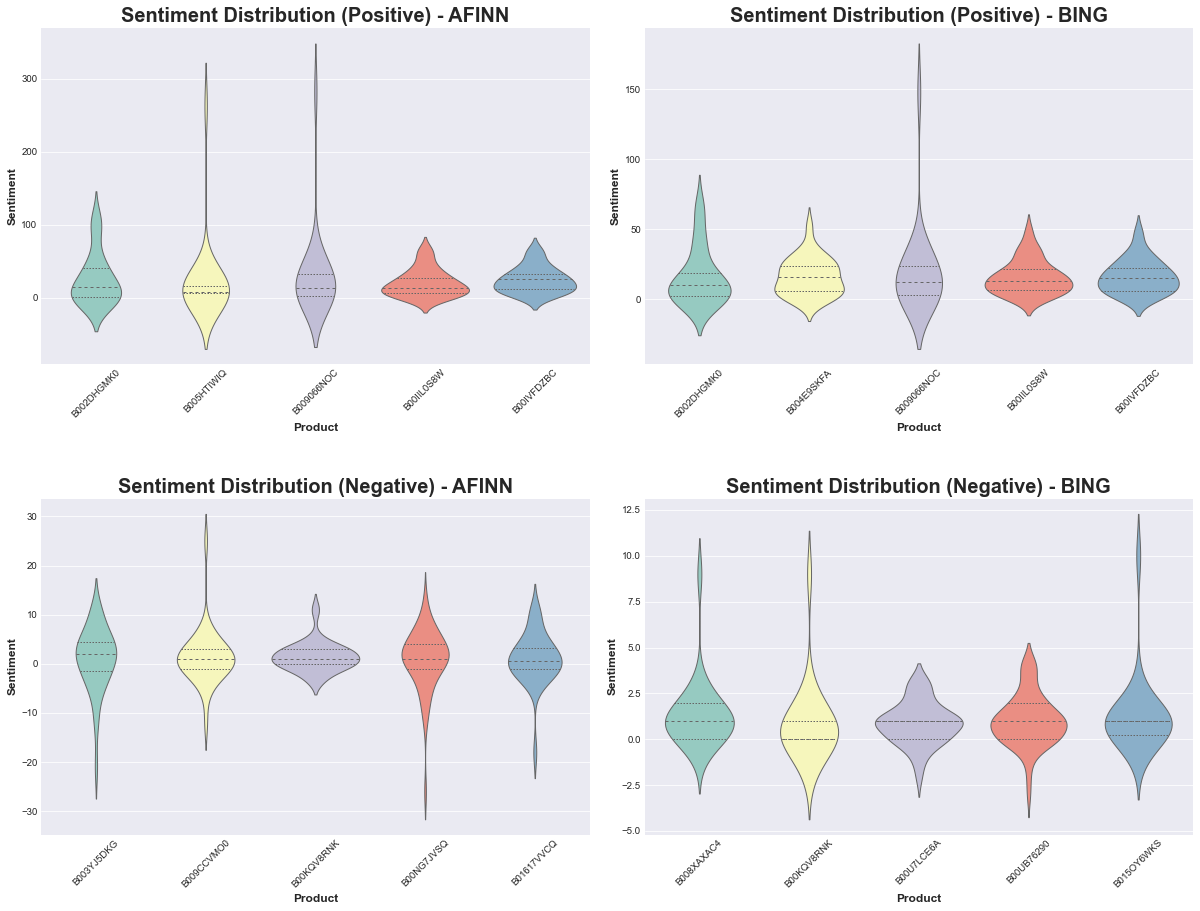

In [51]:
fig = plt.figure(figsize=(20, 14))
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.4)


# AFINN
# plot a violin plot for each product in prod_afinn_data using seaborn for sentiment afinn 
plt.subplot(2, 2, 1)
sns.violinplot(x="asin", y="sentiment_afinn", data=top6_prod_afinn_data, palette="Set3", linewidth=1, inner="quartile")
plt.title("Sentiment Distribution (Positive) - AFINN", fontsize=20, fontweight='bold')
plt.xlabel("Product", fontsize=12, fontweight='semibold')
plt.ylabel("Sentiment", fontsize=12, fontweight='semibold')
plt.xticks(rotation=45)


plt.subplot(2, 2, 3)
sns.violinplot(x="asin", y="sentiment_afinn", data=low_6_prod_afinn_data, palette="Set3", linewidth=1, inner="quartile")
plt.title("Sentiment Distribution (Negative) - AFINN", fontsize=20, fontweight='bold')
plt.xlabel("Product", fontsize=12, fontweight='semibold')
plt.ylabel("Sentiment", fontsize=12, fontweight='semibold')
plt.xticks(rotation=45)


# BING
# plot a violin plot for each product in prod_bing_data using seaborn for sentiment bing
plt.subplot(2, 2, 2)
sns.violinplot(x="asin", y="sentiment_bing", data=top6_prod_bing_data, palette="Set3", linewidth=1, inner="quartile")
plt.title("Sentiment Distribution (Positive) - BING", fontsize=20, fontweight='bold')
plt.xlabel("Product", fontsize=12, fontweight='semibold')
plt.ylabel("Sentiment", fontsize=12, fontweight='semibold')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.violinplot(x="asin", y="sentiment_bing", data=low_6_prod_bing_data, palette="Set3", linewidth=1, inner="quartile")
plt.title("Sentiment Distribution (Negative) - BING", fontsize=20, fontweight='bold')
plt.xlabel("Product", fontsize=12, fontweight='semibold')
plt.ylabel("Sentiment", fontsize=12, fontweight='semibold')
plt.xticks(rotation=45);


In [100]:
# functions which returns the number of positive, negative and neutral reviews for each product
def get_pos_neg_neu_bing(df):
    df_pos = df[df['sentiment_bing'] > 0]
    df_neg = df[df['sentiment_bing'] < 0]
    df_neu = df[df['sentiment_bing'] == 0]
    df_pos = df_pos.groupby(['asin']).agg({"sentiment_bing": ["count"]})
    df_neg = df_neg.groupby(['asin']).agg({"sentiment_bing": ["count"]})
    df_neu = df_neu.groupby(['asin']).agg({"sentiment_bing": ["count"]})
    df_pos = df_pos.merge(df_neg, on='asin', how='outer')
    df_pos = df_pos.merge(df_neu, on='asin', how='outer')
    df_pos.columns = ['pos', 'neg', 'neu']
    df_pos = df_pos.fillna(0)
    df_pos = df_pos.astype(int)
    return df_pos


def get_pos_neg_neu_afinn(df):
    df_pos = df[df['sentiment_afinn'] > 0]
    df_neg = df[df['sentiment_afinn'] < 0]
    df_neu = df[df['sentiment_afinn'] == 0]
    df_pos = df_pos.groupby(['asin']).agg({"sentiment_afinn": ["count"]})
    df_neg = df_neg.groupby(['asin']).agg({"sentiment_afinn": ["count"]})
    df_neu = df_neu.groupby(['asin']).agg({"sentiment_afinn": ["count"]})
    df_pos = df_pos.merge(df_neg, on='asin', how='outer')
    df_pos = df_pos.merge(df_neu, on='asin', how='outer')
    df_pos.columns = ['pos', 'neg', 'neu']
    df_pos = df_pos.fillna(0)
    df_pos = df_pos.astype(int)
    return df_pos

In [101]:
# apply functions to get the number of positive, negative and neutral reviews for each product
prods_reviews_afinn = get_pos_neg_neu_bing(soft_data)
prods_reviews_bing = get_pos_neg_neu_afinn(soft_data)

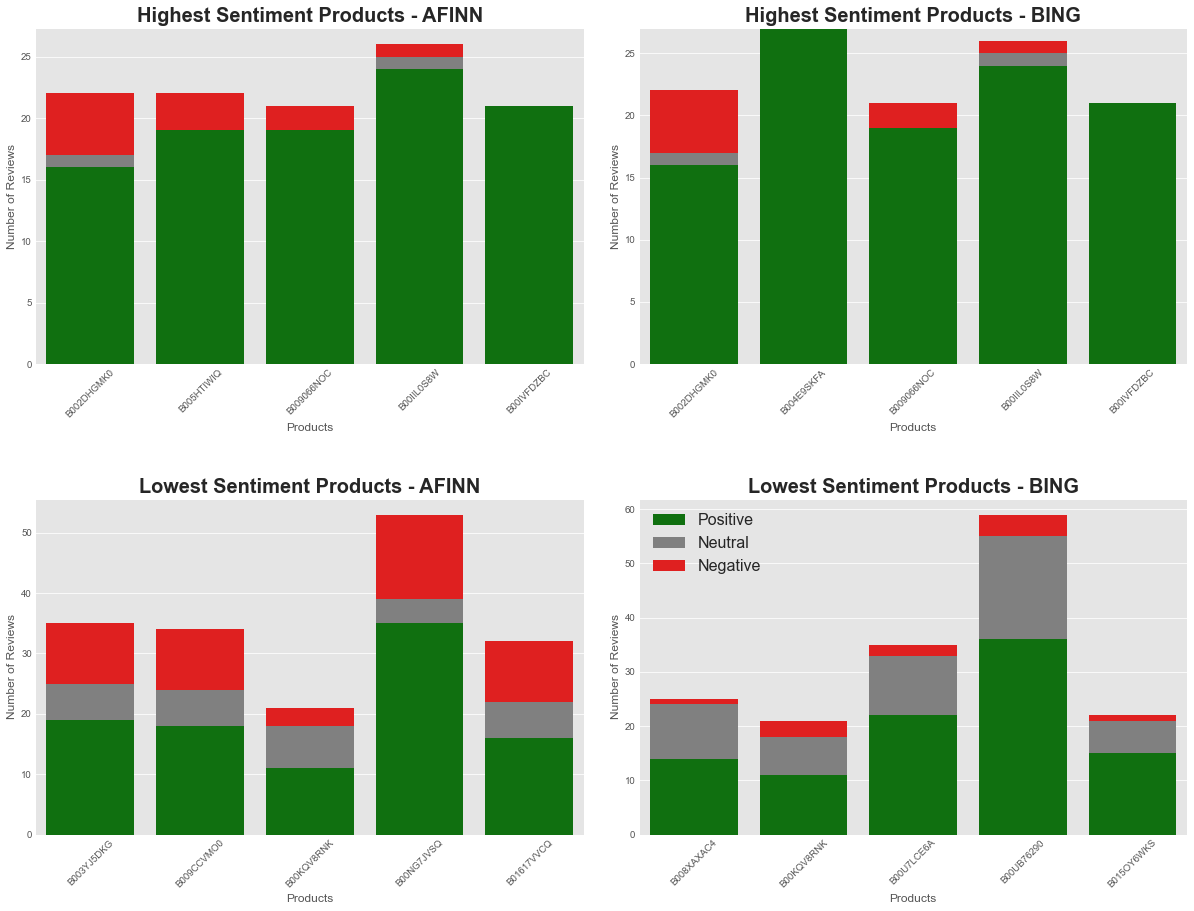

In [108]:
# Highest Sentiments - AFINN
fig = plt.figure(figsize=(20, 14))
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.4)
plt.style.use('ggplot')

plt.subplot(2,2,1)
sns.barplot(x=prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_afinn)].index, y=prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_afinn)].pos, color='green', label='Positive')
sns.barplot(x=prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_afinn)].index, y=prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_afinn)].neu, color='grey', bottom=prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_afinn)].pos, label='Neutral')
sns.barplot(x=prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_afinn)].index, y=prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_afinn)].neg, color='red', bottom=prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_afinn)].neu+prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_afinn)].pos, label='Negative')
plt.title('Highest Sentiment Products - AFINN', fontsize=20, fontweight='bold')
plt.xlabel('Products')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)



# Lowest Sentiments - AFINN
plt.subplot(2,2,3)
sns.barplot(x=prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_afinn)].index, y=prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_afinn)].pos, color='green', label='Positive')
sns.barplot(x=prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_afinn)].index, y=prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_afinn)].neu, color='grey', bottom=prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_afinn)].pos, label='Neutral')
sns.barplot(x=prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_afinn)].index, y=prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_afinn)].neg, color='red', bottom=prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_afinn)].neu+prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_afinn)].pos, label='Negative')
plt.title('Lowest Sentiment Products - AFINN', fontsize=20, fontweight='bold')
plt.xlabel('Products')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)



# Highest Sentiments - BING
plt.subplot(2,2,2)
sns.barplot(x=prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_bing)].index, y=prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_bing)].pos, color='green', label='Positive')
sns.barplot(x=prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_bing)].index, y=prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_bing)].neu, color='grey', bottom=prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_bing)].pos, label='Neutral')
sns.barplot(x=prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_bing)].index, y=prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_bing)].neg, color='red', bottom=prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_bing)].neu+prods_reviews_bing[prods_reviews_bing.index.isin(top6_prod_bing)].pos, label='Negative')
plt.title('Highest Sentiment Products - BING', fontsize=20, fontweight='bold')
plt.xlabel('Products')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)


# Lowest Sentiments - BING
plt.subplot(2,2,4)
sns.barplot(x=prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_bing)].index, y=prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_bing)].pos, color='green', label='Positive')
sns.barplot(x=prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_bing)].index, y=prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_bing)].neu, color='grey', bottom=prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_bing)].pos, label='Neutral')
sns.barplot(x=prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_bing)].index, y=prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_bing)].neg, color='red', bottom=prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_bing)].neu+prods_reviews_bing[prods_reviews_bing.index.isin(low_6_prod_bing)].pos, label='Negative')
plt.title('Lowest Sentiment Products - BING', fontsize=20, fontweight='bold')
plt.xlabel('Products')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize = 16)



### <a id='toc6_1_3_'></a>[Tokenization](#toc0_)

**Token and Tokenization**: The process of **breaking a text corpus into smaller units**, typically *words*, *phrases*, or *sentences*. Tokenization is the first step in most natural language processing tasks, as it helps to normalize the text and make it more amenable to further analysis.
- **e.g.** given the sentence "The quick brown fox jumps over the lazy dog", tokenization would break the sentence into a list of individual words: ["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"].

**Stemming**: The process of **reducing a word to its base or root form** by removing suffixes and prefixes. The resulting form, called the stem, may not be a real word, but it captures the essential meaning of the original word. It may not always produce meaningful base forms.


- **e.g.**, stemming the word "jumped" would result in the stem "jump", and stemming the word "running" would result in the stem "run". Stemming can help to reduce the number of unique words in a text corpus and make it easier to analyze.


**Lemmatizing**: The process of **reducing a word to its base or dictionary form**, called the lemma, by applying morphological analysis to the word (i.e, involves analyzing the structure of words to determine their base form or lemma). The resulting lemma is a real word that conveys the same meaning as the original word. Lemmatization is a more sophisticated version of stemming that produces more accurate and meaningful lemmas,  but it is also more computationally intensive.

**Stop Words**: Common words that are typically removed from a text corpus before analysis because they do not add much meaning or value to the text. Removing stop words can help to reduce the noise in a text corpus and make it easier to focus on the more meaningful words.
- **e.g.**, of stop words include "the", "a", "an", "and", "in", "on", "at", and so on.


In [110]:
# tokenize text data into words
from nltk.tokenize import word_tokenize

# tokenize text data into words and remove stop words and punctuation marks using NLTK library
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer

# function to tokenize text data
def tokenize(text):
    # tokenize text data into words
    tokens = word_tokenize(text)
    # remove stop words and punctuation marks
    tokens = [w for w in tokens if w not in stopwords.words('english')]
    tokens = [w for w in tokens if w.isalpha()]
    # lemmatize words
    # lemmatizer = WordNetLemmatizer()
    # tokens = [lemmatizer.lemmatize(w) for w in tokens]
    # stem words
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(w) for w in tokens]
    return tokens

In [111]:
# tokenize text data using tokenize function
soft_data['token_reviewText'] = soft_data['reviewText'].apply(tokenize)

In [133]:
# make each word in token_reviewText as a row   
word_tokens = soft_data.explode('token_reviewText')[['reviewerID', 'reviewerName', 'asin', 'token_reviewText']]

# load afinn and bing lexicon from csv files
afinn = pd.read_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/My Github/Recommender-Systems/Data/Lexicons/Afinn.csv', sep=',', header=1)
afinn.columns = ['word', 'score']

# attach sentiment score to each word using AFINN
word_tokens_afinn = pd.merge(word_tokens, afinn, how='left', left_on='token_reviewText', right_on='word')

,reviewerID,reviewerName,asin,token_reviewText,word,score
0,A38NELQT98S4H8,WB Halper,0321719816,i,NaN,NaN
1,A38NELQT98S4H8,WB Halper,0321719816,use,NaN,NaN
2,A38NELQT98S4H8,WB Halper,0321719816,dreamweav,NaN,NaN
3,A38NELQT98S4H8,WB Halper,0321719816,predecessor,NaN,NaN
4,A38NELQT98S4H8,WB Halper,0321719816,macromedia,NaN,NaN
...,...,...,...,...,...,...
1156262,A1F1A0QQP2XVH5,Mark B,B005IHT91Q,autocad,NaN,NaN
1156263,A1F1A0QQP2XVH5,Mark B,B005IHT91Q,excel,NaN,NaN
1156264,A1F1A0QQP2XVH5,Mark B,B005IHT91Q,implement,NaN,NaN
1156265,A1F1A0QQP2XVH5,Mark B,B005IHT91Q,profession,NaN,NaN


The merge function combines these two data frames by matching their rows based on the values in a specific column of each dataframe. In this case, the `how` parameter is set to '`left`', which means that all rows from the `word_tokens` dataframe will be included in the merged dataframe, and any matching rows from the `afinn` dataframe will be included as well. If there are rows in `word_tokens` that do not have a match in `afinn`, those rows will still be included in the output, but with missing values in the `word` and `score` columns.



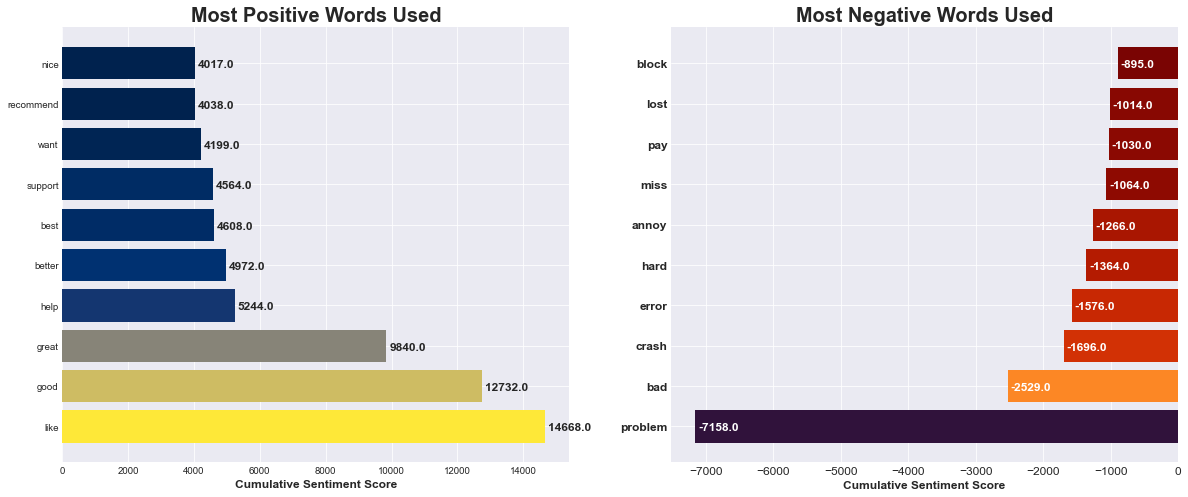

In [158]:
# most positive words used by customers in reviews using AFINN lexicon 
sample1 = word_tokens_afinn.groupby('token_reviewText')['score'].sum().sort_values(ascending=False).head(10)

# most negative words used by customers in reviews using AFINN lexicon 
sample2 = word_tokens_afinn.groupby('token_reviewText')['score'].sum().sort_values(ascending=True).head(10)

# create figure
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(20, 8))

# Plot the bar plot -- 1
min = sample1.min()
max = sample1.max()
norm = (sample1 - min) / (max - min) 
colors = cm.cividis(norm) 

plt.subplot(1, 2, 1)
bar = plt.barh(y=sample1.index, width=sample1.values, color=colors)
plt.title("Most Positive Words Used", fontsize=20, fontweight='bold')
plt.xlabel("Cumulative Sentiment Score", fontsize=12, fontweight='semibold')
plt.ylabel("", fontsize=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 15), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12)

# Plot the bar plot -- 2
min = sample2.min()
max = sample2.max()
norm = (sample2 - min) / (max - min) 
colors = cm.turbo(norm) 

plt.subplot(1, 2, 2)
bar = plt.barh(y=sample2.index, width=sample2.values, color=colors)
plt.title("Most Negative Words Used", fontsize=20, fontweight='bold')
plt.xlabel("Cumulative Sentiment Score", fontsize=12, fontweight='semibold')
plt.ylabel("", fontsize=12, fontweight='semibold')
plt.xticks(size=12)
plt.yticks(size=12, fontweight='semibold')
for i, value in enumerate(bar.patches):
    height = value.get_width()
    plt.annotate(f'{height}',
                xy=(height, value.get_y()),
                xytext=(3, 15), 
                textcoords="offset points",
                ha='left', va='center',
                weight='semibold',
                fontsize=12, 
                color = 'white')

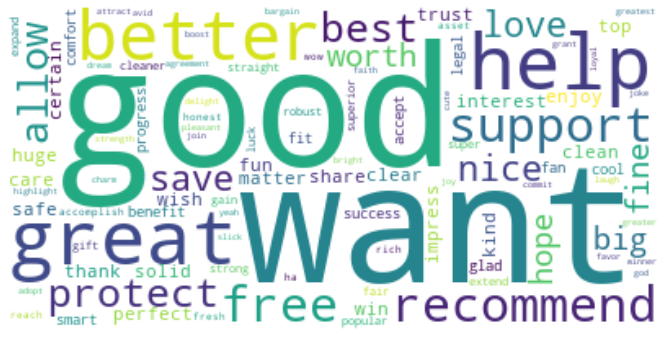

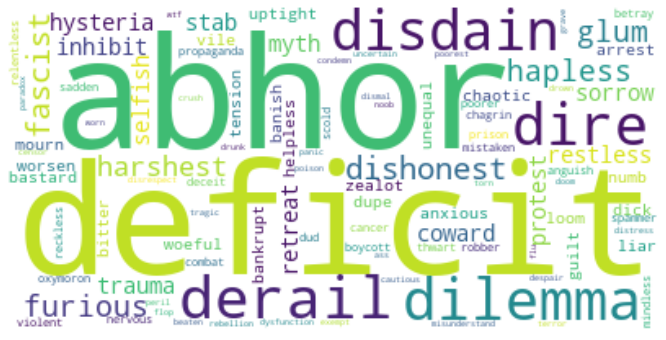

In [164]:
# word cloud for most positive words used by customers in reviews using AFINN lexicon
from wordcloud import WordCloud

# get most common positive words
most_common_positive_words = word_tokens_afinn[word_tokens_afinn['score'] > 0].groupby('token_reviewText')['score'].count().sort_values(ascending=False).head(100).index

# get most common negative words
most_common_negative_words = word_tokens_afinn[word_tokens_afinn['score'] < 0].groupby('token_reviewText')['score'].count().sort_values(ascending=True).head(100).index

# Generate word cloud for most common positive words
fig = plt.figure(figsize=(15, 6))
wordcloud = WordCloud(background_color='white').generate(' '.join(most_common_positive_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate word cloud for most common negative words
fig = plt.figure(figsize=(15,6))
wordcloud = WordCloud(background_color='white').generate(' '.join(most_common_negative_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Feature Generation

There are a variety of ways to use sentiment analysis to generate additional features for a recommender system based on user reviews. Note that the effectiveness of this technique will vary greatly according to what type of recommender system you are building.  

However, here are some ways we can do this are listed below: 

<br>

1. **Sentiment Score**
    - can use a sentiment analysis algorithm to calculate the sentiment score for each review, which can be used as a feature in your recommender system. The sentiment score can be a value between 0 and 1, where 0 indicates a negative sentiment and 1 indicates a positive sentiment.

<br>

2. **Positive and Negative Reviews**
    - can classify reviews as positive or negative based on the sentiment score. This binary classification can be used as a feature in your recommender system.

<br>

3. **Sentiment-based Rating Adjustment**
    - adjust the ratings given by the users based on the sentiment of their reviews. For example, if a user gave a high rating to a product but the sentiment of their review is negative, you can adjust the rating downwards.

<br>

4. **Sentiment-based Similarity Metric**
    - calculate the similarity between users or items based on their sentiment scores. This can be used as a feature in your collaborative filtering algorithm to identify users or items that have similar sentiment scores.

<br>

5. **Sentiment-based User Profile**
    - You can use sentiment analysis to analyze the sentiment of the user's profile or preferences. This can help you identify users who have a preference for items with positive or negative sentiment and recommend items to them accordingly.




In [210]:
# data set for recommender systems
soft_data[['reviewerID', 'reviewerName', 'asin','new_review', 'overall', 'new_title', 'new_brand', 'description', 'sentiment_afinn', 'sentiment_bing']]

,reviewerID,reviewerName,asin,new_review,overall,new_title,new_brand,description,sentiment_afinn,sentiment_bing
0,A38NELQT98S4H8,WB Halper,0321719816,i ve been using dreamweaver and it s predecess...,4,learn adobe dreamweaver cs5 by video core trai...,peach pit press,['This complete training program from Adobe Pr...,17.0,11
1,A3QJU4FEN8PQSZ,Grimmy,0321719816,the demo is done with the pc version with refe...,4,learn adobe dreamweaver cs5 by video core trai...,peach pit press,['This complete training program from Adobe Pr...,12.0,-6
2,ACJT8MUC0LRF0,D. Fowler,0321719816,if you ve been wanting to learn how to create ...,5,learn adobe dreamweaver cs5 by video core trai...,peach pit press,['This complete training program from Adobe Pr...,47.0,24
3,AYUF7YETYOLNX,Bryan Newman,0321719816,i ve been creating websites with dreamweaver f...,5,learn adobe dreamweaver cs5 by video core trai...,peach pit press,['This complete training program from Adobe Pr...,26.0,18
4,A31ICLWQ9CSHRS,Al Swanson,0321719816,i decided after trying a number of other produ...,5,learn adobe dreamweaver cs5 by video core trai...,peach pit press,['This complete training program from Adobe Pr...,18.0,7
...,...,...,...,...,...,...,...,...,...,...
14098,A1WXG10FJ353K0,M,B005IHT91Q,i had wrote a lengthy review of this version s...,5,autocad 2012 for mac includes 1 year autodesk ...,autodesk,['Design and shape the world around you with A...,2.0,3
14099,A1M85S3L9ROA17,C. Jong,B005IHT91Q,i ve never really like the windows operating s...,4,autocad 2012 for mac includes 1 year autodesk ...,autodesk,['Design and shape the world around you with A...,25.0,16
14100,A7H1LWFBE905R,KWJ,B005IHT91Q,autocad has been the industry standard for 3d ...,5,autocad 2012 for mac includes 1 year autodesk ...,autodesk,['Design and shape the world around you with A...,14.0,15
14101,A225G2TFM76GYX,J. White,B005IHT91Q,autocad 2012 is the reference standard drawing...,4,autocad 2012 for mac includes 1 year autodesk ...,autodesk,['Design and shape the world around you with A...,13.0,7


For our recommender systems, we can consider using a sentiment-based rating adjustment, as we see several cases where the sentiment from a user is negative but the overall rating for the product is high (4+). Similarly, we have several hundred reviews were the rating was low (below 3) and the sentiment was quite high from the review. 

In [207]:
# reviews which have 4 plus stars but negative sentiment using AFINN lexicon
print("High Ratings with Negative Sentiment (AFINN): ", soft_data[(soft_data['overall'] >= 3.5) & (soft_data['sentiment_afinn'] <= -10)].shape)

# reviews which have 4 plus stars but negative sentiment using Bing lexicon
print("High Ratings with Negative Sentiment (BING): ", soft_data[(soft_data['overall'] >= 3.5) & (soft_data['sentiment_bing'] <= -5)].shape)

# reviews which have 3 or less stars but positive sentiment using AFINN lexicon
print("Low Ratings with Positive Sentiment (AFINN): ", soft_data[(soft_data['overall'] <= 3) & (soft_data['sentiment_afinn'] >= 15)].shape)

# reviews which have 3 or less stars but positive sentiment using Bing lexicon
print("Low Ratings with Positive Sentiment (BING): ", soft_data[(soft_data['overall'] <= 3) & (soft_data['sentiment_bing'] >= 10)].shape)

High Ratings with Negative Sentiment (AFINN):  (26, 15)
High Ratings with Negative Sentiment (BING):  (19, 15)
Low Ratings with Positive Sentiment (AFINN):  (458, 15)
Low Ratings with Positive Sentiment (BING):  (664, 15)


***
# <a id='toc7_'></a>[Collaborative Filtering](#toc0_)





## <a id='toc7_1_'></a>[Non-negative Matrix Factorisation](#toc0_)

## <a id='toc7_3_'></a>[Neural Collaborative Filtering](#toc0_)

***
# <a id='toc8_'></a>[Content Based Filtering](#toc0_)

CBFs or content based filtering  recommender systems **use the content or attributes of items**, such as genre, director, actor, or tags, to recommend items that are similar to those the user has previously interacted with. 

### Metadata
The metadata for our content based filtering recommender system will include:

- new_review: cleaned and preprocessed review text from users
- new_title: cleaned and preprocessed name of the product reviewed by user
- new_brand: cleaned and preprocessed brand name for product reviewed
- description: cleaned and preprocessed description of the product reviewed 

### Methodology 
Since we have many users who have purchased (reviewed) many products. We will need to geenrate a contnet based filtering system that:

<br>

1. **calculates the similarity scores** between the features of different products. 
    - e.g., you could compute the cosine similarity between the vectorized product titles or descriptions. This would give you a similarity score between 0 and 1, where 1 indicates that two products are very similar and 0 indicates that they are dissimilar.

<br>

2. then we **use this similarity score to recommend products** to users who have shown a preference for similar products in the past. Note, that in the recommended list the products should not have been already reviwed by this user.
    - e.g. you could recommend the top-k most similar products (not purchased by user)
    - filter out products that the user has already purchased or interacted with in the past. You want to recommend products that the user has not yet

<br>

### Using Review Text as Metadata

Although it may not be easy to reason why one would include review text as metadata for our content based filtering system, it does provide some substantial benefits. Review text can provide a lot of valuable information about a product, such as its features, benefits, drawbacks, and overall quality. This information can be used to identify similar products that are likely to appeal to the same users.

To do this, I shall **combine the reviews for each product into a single record**, so that you have one record per product that contains all of the relevant information about that product. This will make it easier to calculate similarity scores between products and generate recommendations based on those scores.

> we combine text reviews for each product into a single column. So a row represents a product with all its metadata.

### Using Sentiments as Metadata

We can also make use of our sentiment analysis, by incorporating overall sentiment for a product, which can be a useful feature to include in our content-based filtering system. 

To calculate the overall sentiment for a product, we shall make use of our sentiment scores that we have obtained for each review in `soft_data`. We shall then aggregate the sentiment scores to get an overall sentiment score for the product. This score could then be used as an additional feature in your similarity calculation between products. 

### Summary of Steps
Ultimately, our new dataframe after processing the metadata, will be such that each row represents a unique product, with all of the relevant metadata, concatenated review text, and an overall sentiment score for that product

## Using Sentiment with Text Metadata

In [213]:

cbf_data = soft_data.copy()[['reviewerID', 'asin','new_review', 'overall', 'new_title', 'new_desc', 'new_brand', 'sentiment_bing']]
cbf_data.head(3)

,reviewerID,asin,new_review,overall,new_title,new_desc,new_brand,sentiment_bing
0,A38NELQT98S4H8,0321719816,i ve been using dreamweaver and it s predecess...,4,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press,11
1,A3QJU4FEN8PQSZ,0321719816,the demo is done with the pc version with refe...,4,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press,-6
2,ACJT8MUC0LRF0,0321719816,if you ve been wanting to learn how to create ...,5,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press,24


In [217]:
# create a new column for CBF (title + description + brand + review)
cbf_data['meta'] = cbf_data['new_title'] + ' ' + cbf_data['new_desc'] + ' ' + cbf_data['new_brand'] + ' ' + cbf_data['new_review']
cbf_data.head(3)

,reviewerID,asin,new_review,overall,new_title,new_desc,new_brand,sentiment_bing,content,meta
0,A38NELQT98S4H8,0321719816,i ve been using dreamweaver and it s predecess...,4,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press,11,learn adobe dreamweaver cs5 by video core trai...,learn adobe dreamweaver cs5 by video core trai...
1,A3QJU4FEN8PQSZ,0321719816,the demo is done with the pc version with refe...,4,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press,-6,learn adobe dreamweaver cs5 by video core trai...,learn adobe dreamweaver cs5 by video core trai...
2,ACJT8MUC0LRF0,0321719816,if you ve been wanting to learn how to create ...,5,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press,24,learn adobe dreamweaver cs5 by video core trai...,learn adobe dreamweaver cs5 by video core trai...


Now we have all our text metadata joined in one column separated by spaces. Next we move onto getting our aggregated sentiment for each product. We do this by simply getting the average sentiment for each product. We shall attach this in column '`agg_sentiment`' in `cbf_data` dataframe.

In [221]:
# new column with average sentiment score for each product
cbf_data['avg_sentiment'] = cbf_data.groupby('asin')['sentiment_bing'].transform('mean')
cbf_data.head(3)

,reviewerID,asin,new_review,overall,new_title,new_desc,new_brand,sentiment_bing,content,meta,avg_sentiment
0,A38NELQT98S4H8,0321719816,i ve been using dreamweaver and it s predecess...,4,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press,11,learn adobe dreamweaver cs5 by video core trai...,learn adobe dreamweaver cs5 by video core trai...,11.071429
1,A3QJU4FEN8PQSZ,0321719816,the demo is done with the pc version with refe...,4,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press,-6,learn adobe dreamweaver cs5 by video core trai...,learn adobe dreamweaver cs5 by video core trai...,11.071429
2,ACJT8MUC0LRF0,0321719816,if you ve been wanting to learn how to create ...,5,learn adobe dreamweaver cs5 by video core trai...,this complete training program from adobe pres...,peach pit press,24,learn adobe dreamweaver cs5 by video core trai...,learn adobe dreamweaver cs5 by video core trai...,11.071429


Now we can look at reducing our data frame from a review per row to a product per row. This is our aim, as it makes calculating the simialrity between products a lot more straightforward. 

In [231]:
# get dataframe with unique products
unique_products = cbf_data[['asin', 'meta', 'avg_sentiment']].drop_duplicates(subset=['asin'], keep='first')
display(unique_products.head(5))
print("Shape of new dataframe:", unique_products.shape)

,asin,meta,avg_sentiment
0,0321719816,learn adobe dreamweaver cs5 by video core trai...,11.071429
14,0321700945,learn adobe photoshop lightroom 3 by video thi...,7.750000
22,0321719824,learn adobe flash professional cs5 by video co...,11.222222
31,0763855553,microsoft office 365 home 1 year subscription ...,7.194444
67,0982697813,niv glo premium dvd multi device glo features ...,17.666667


Shape of new dataframe: (802, 3)


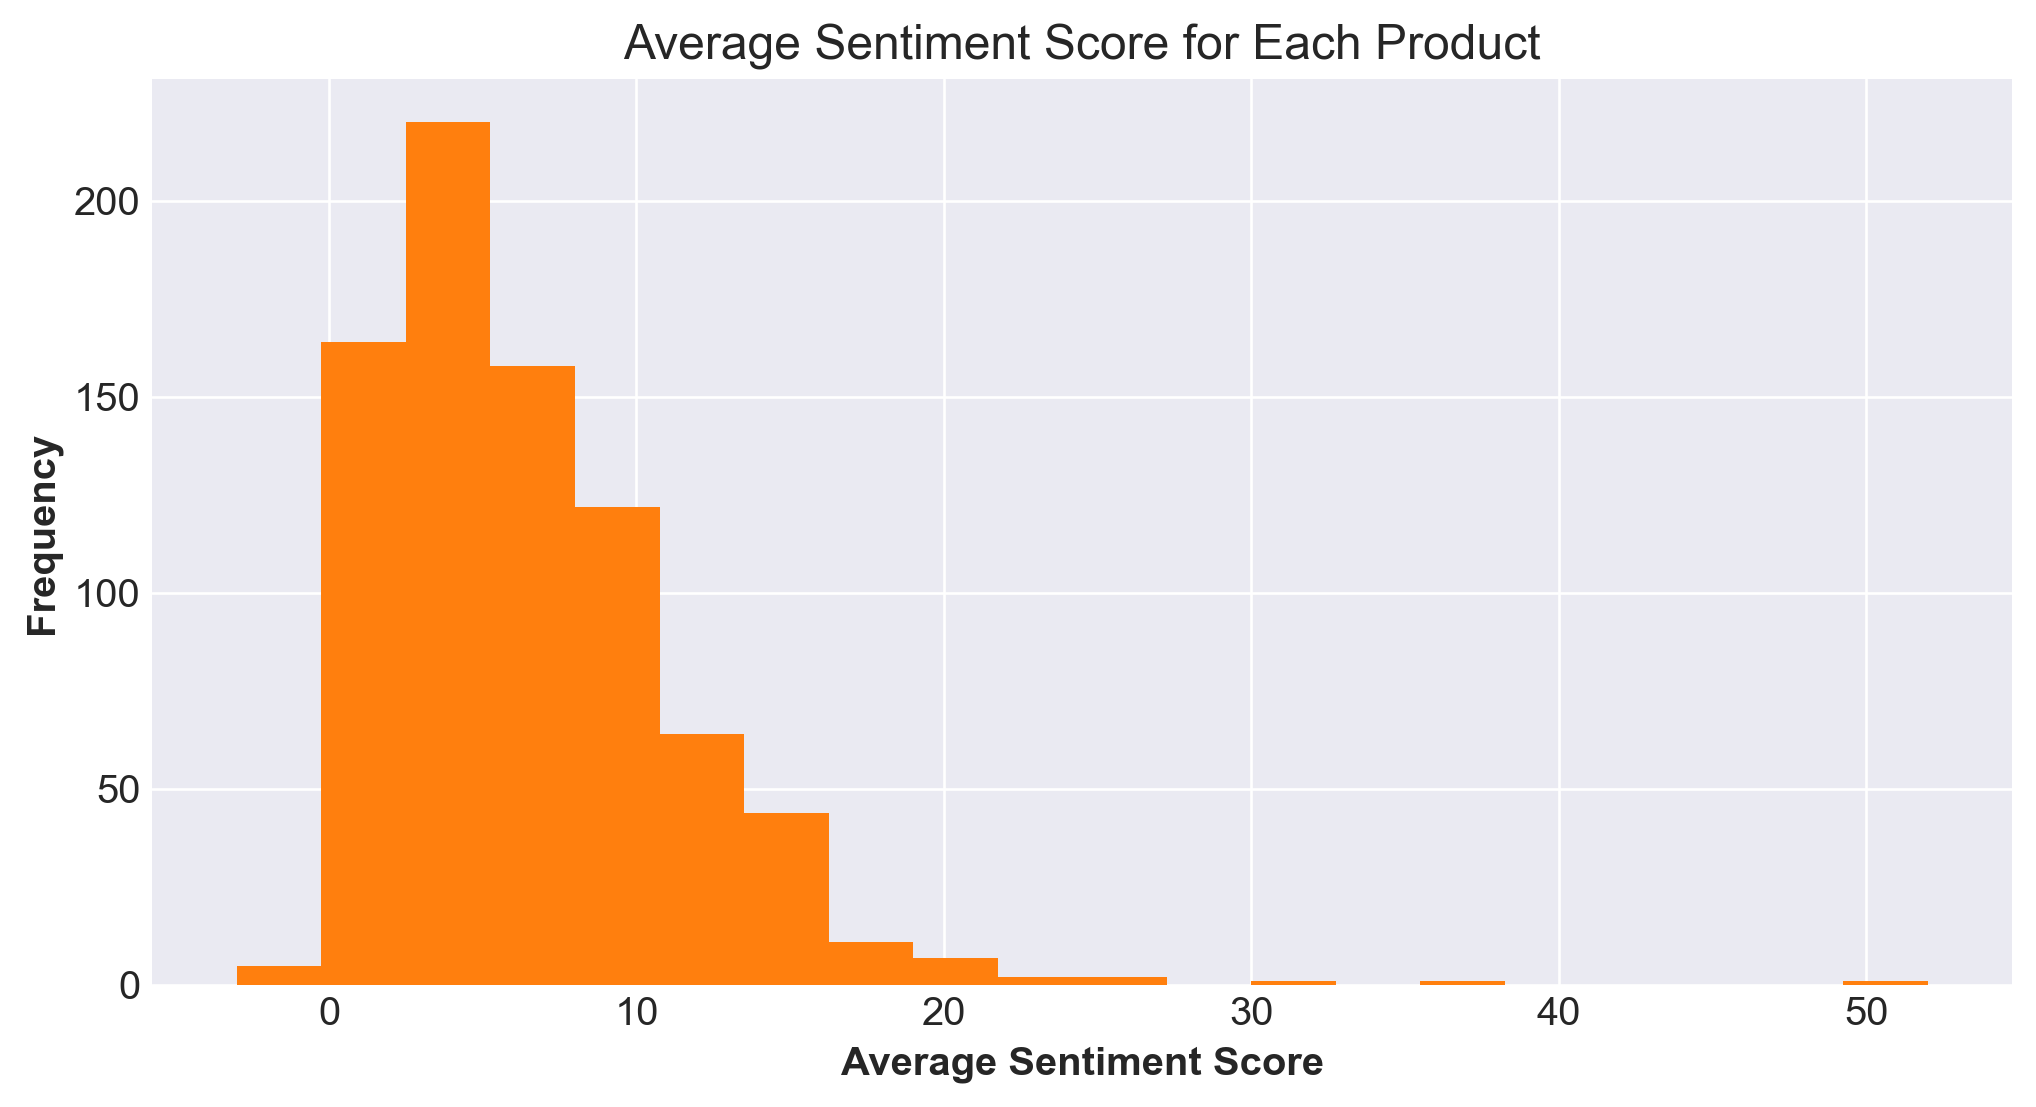

In [393]:
# Average Sentiment Score for Each Product
fig = plt.figure(num=None, dpi=240, facecolor='w', edgecolor='k')
unique_products.avg_sentiment.plot(kind='hist', bins=20, figsize=(10, 5), title='Average Sentiment Score for Each Product', color='#ff7f0e')
plt.xlabel('Average Sentiment Score', fontsize=12, fontweight='semibold')
plt.ylabel('Frequency', fontsize=12, fontweight='semibold')
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

The next steps are that we use the `CountVectorizer()`. This will generate our DTM. 
- `CountVectorizer` class from the `sklearn.feature_extraction.text` module, which is a tool for transforming a collection of text documents into a numerical representation.

- The `CountVectorizer` class is an implementation of a bag-of-words model.

In [233]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(unique_products['meta'])

# shape 
print("Shape of DTM:", count_matrix.shape)

Shape of DTM: (802, 15327)


So we have 802 products (documents) and 15 327 words (vocabulary). We can now take our DTM and concatenate it with the numerical feature - sentiment avergae - to ceate a feature representation for each product that combines both numerical and text data. 

In [344]:
# import standard scaler
from sklearn.preprocessing import StandardScaler

# text features
text_fxs = count_matrix.toarray()
print("Shape of text features:", text_fxs.shape)

# numerical features (scaled)
num_fxs = unique_products[['asin', 'avg_sentiment']]
num_fxs = num_fxs.set_index(['asin'], drop=True)
scaler = StandardScaler()
scaler.fit(num_fxs)
num_fxs = scaler.transform(num_fxs)
print("Shape of Numerical Data:", num_fxs.shape)


Shape of text features: (802, 15327)
Shape of Numerical Data: (802, 1)


In [345]:
# combine text and numerical features
all_fxs = np.hstack((num_fxs, text_fxs))
print("Shape of Stacked Array:", all_fxs.shape)

Shape of Stacked Array: (802, 15328)


So we combined our numerical and text features into an array. **The resulting `all_fxs` array is a 2D array with the same number of rows as the unique products dataframe (*number of products*) and a number of columns equal to the number of numerical features plus the number words (*vocabulary in text data*).**
> Each row represents a product, and each column represents a feature

We can use this array as input to similarity metric to make recommendations based on both numerical and text metadata.


    Now all we have to do is apply and calculate the similarity scores between products. We shall be using cosine similarity.  

In [346]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

# calculate cosine sim and get similarity matrix
cbf_sim_mat = cosine_similarity(all_fxs, all_fxs)

# lets look at similarity matrix
np.fill_diagonal(cbf_sim_mat,0) # make diagonal elements 0
cbf_sim_mat = pd.DataFrame(cbf_sim_mat)
cbf_sim_mat.index = unique_products.asin
cbf_sim_mat.columns = unique_products.asin
display(cbf_sim_mat.head(10))

asin,0321719816,0321700945,0321719824,0763855553,0982697813,1413313701,1413313728,1426296355,1600775411,1615354336,...,B0014A2LJ8,B0014A0UDC,B0015CA9VW,B0016PT3BK,B0016XAKZK,B00170IFYU,B0017U9Q2U,B0017XHKYI,B0017XHD40,B005IHT91Q
asin,,,,,,,,,,,,,,,,,,,,,
0321719816,0.000000,0.668960,0.638013,0.080870,0.110836,0.252599,0.062119,0.043765,0.073505,0.096819,...,0.091320,0.154705,0.122814,0.030356,0.039170,0.037533,0.170635,0.029858,0.183810,0.091639
0321700945,0.668960,0.000000,0.598064,0.079165,0.122963,0.219891,0.078357,0.097588,0.131176,0.099624,...,0.160563,0.185821,0.164694,0.007307,0.071553,0.094615,0.201598,0.021409,0.217370,0.125734
0321719824,0.638013,0.598064,0.000000,0.069593,0.117274,0.212198,0.111700,0.042772,0.138116,0.077028,...,0.056768,0.124326,0.117563,0.008134,0.051469,0.133613,0.119597,0.028412,0.179080,0.073975
0763855553,0.080870,0.079165,0.069593,0.000000,0.118619,0.025452,0.020670,0.015019,0.019517,0.068285,...,0.352058,0.191758,0.192330,0.055464,0.043942,0.022331,0.329976,0.009437,0.126530,0.297655
0982697813,0.110836,0.122963,0.117274,0.118619,0.000000,0.134982,0.112235,0.106368,0.120433,0.217582,...,0.078193,0.049914,0.223171,0.032205,0.111104,0.087544,0.051607,0.043758,0.112146,0.124257
1413313701,0.252599,0.219891,0.212198,0.025452,0.134982,0.000000,0.275723,0.026123,0.079013,0.109918,...,0.067555,0.097129,0.139947,0.055433,0.066389,0.021511,0.091027,0.032300,0.121344,0.089024
1413313728,0.062119,0.078357,0.111700,0.020670,0.112235,0.275723,0.000000,0.069749,0.079837,0.082750,...,0.025252,0.030201,0.100510,0.018522,0.141966,0.046010,0.080295,0.076877,0.071297,0.032150
1426296355,0.043765,0.097588,0.042772,0.015019,0.106368,0.026123,0.069749,0.000000,0.061425,0.130075,...,0.051001,0.106966,0.061524,0.018165,0.029984,0.025824,0.107597,0.036025,0.076824,0.037694
1600775411,0.073505,0.131176,0.138116,0.019517,0.120433,0.079013,0.079837,0.061425,0.000000,0.105844,...,0.036239,0.096177,0.150621,0.017249,0.032481,0.084687,0.035855,0.044525,0.128305,0.065008


Now to generate user recommendations need to consider two things. 

1. We need to recommend products which the user has not reviewed (interacted with)

2. We need to recommend products that are similar to the products that the user has reviewed

Now to achieve these we can (1) filter our results to return only product recommnedations for products the user has not reviewed and (2) generate a personalised reocmmendation by looking at the simialrities between products and each of the products that the user has reviewed before. 

Specifically, for (2), we want to calculate the similarity scores between each reviewed product and all the other products, using the content-based filtering approach. Then, for each of the reviewed products, we will generate a list of the top recommended products based on their similarity scores. Finally, we combine these lists and select the top 10 products based on their overall similarity scores.

In [347]:
# get products reviewed by a user
user_products = cbf_data[cbf_data['reviewerID'] == 'A38NELQT98S4H8']['asin']


# similarity with all products
user_sim_mat = cbf_sim_mat.loc[user_products, ]

# create a new dataframe to store the similarity scores
sim_scores = pd.DataFrame(columns=['asin', 'sim_score'])

for i, product in enumerate(user_products):
    new_scores = pd.DataFrame({'asin': user_sim_mat.loc[product,:].sort_values(ascending=False).head(15).index,
                                'sim_score': user_sim_mat.loc[product,:].sort_values(ascending=False).head(15).values})
    sim_scores = pd.concat([sim_scores, new_scores])

# get unique products from sim_scores, take the highest score for each product
sim_scores = sim_scores.groupby('asin')['sim_score'].max().reset_index()

# get the top 10 products, sort by similarity score
sim_scores = sim_scores.sort_values(by='sim_score', ascending=False)

# filter out products already rated by user
sim_scores = sim_scores[~sim_scores['asin'].isin(user_products.values)]
sim_scores.head(10)

# get product title and brand for the top 10 products
top_10 = soft_data[soft_data.asin.isin(sim_scores.asin.values)][['asin', 'new_title', 'new_brand']].drop_duplicates(subset=['asin'], keep='first')
top_10

,asin,new_title,new_brand
14,0321700945,learn adobe photoshop lightroom 3 by video,peach pit press
22,0321719824,learn adobe flash professional cs5 by video co...,peach pit press
746,B00005LBVS,the learning company oregon trail 5th edition,the learning company
962,B00006FI0N,norton internet security 2003,symantec
1939,B000BAV2FG,norton antivirus 2006 old version,symantec
...,...,...,...
13855,B01AC3ZA7C,corel videostudio pro x9 old version,corel
13886,B01CS8RSIS,cyberlink powerdvd 16 ultra,cyberlink
14035,B01HAP3NUG,pinnacle studio 20 plus old version,pinnacle systems
14049,B01HAP47PQ,pinnacle studio 20 ultimate old version,pinnacle systems


So now we have generated a content based filtering apporach recommendation for user `A38NELQT98S4H8`. Now lets geernalise these workings and create a function for which we can supply any user and get a top 10 recommendation. 

In [364]:
# generate function to recommend products to a user
def cbf_recommender(user, k, sim_mat):
    
    # get user name from user id
    user_name = soft_data[soft_data['reviewerID'] == user]['reviewerName'].values[0]
    
    # get products reviewed by a user
    user_products = cbf_data[cbf_data['reviewerID'] == user]['asin']

    # similarity with all products
    user_sim_mat = sim_mat.loc[user_products, ]

    # Get all similarity scores for the products rated by the user
    sim_scores = pd.DataFrame(columns=['asin', 'sim_score'])
    for i, product in enumerate(user_products):
        new_scores = pd.DataFrame({'asin': user_sim_mat.loc[product,:].sort_values(ascending=False).index,
                                   'sim_score': user_sim_mat.loc[product,:].sort_values(ascending=False).values})
        sim_scores = pd.concat([sim_scores, new_scores])

    # get unique products from sim_scores (take the highest score for each product)
    sim_scores = sim_scores.groupby('asin')['sim_score'].max().reset_index()

    # get the top products, sort by similarity score
    sim_scores = sim_scores.sort_values(by='sim_score', ascending=False)

    # filter out products already rated by user
    sim_scores = sim_scores[~sim_scores['asin'].isin(user_products.values)]

    # get product title and brand for the top k products
    top_k = soft_data[soft_data.asin.isin(sim_scores.asin.values)][['asin', 'new_title', 'new_brand']].drop_duplicates(subset=['asin'], keep='first').head(k)

    
    # return top k products
    return print("The Recommended Software Products for", user_name,
                 "using CBF Model are: \n \n", top_k, "\n")

In [368]:
# test function
cbf_recommender(user = 'A3QJU4FEN8PQSZ', k = 5, sim_mat=cbf_sim_mat)

# test function
cbf_recommender(user = 'A1F1A0QQP2XVH5', k = 10, sim_mat=cbf_sim_mat)

The Recommended Software Products for Grimmy using CBF Model are: 
 
           asin                                          new_title  \
14  0321700945         learn adobe photoshop lightroom 3 by video   
31  0763855553  microsoft office 365 home 1 year subscription ...   
67  0982697813                   niv glo premium dvd multi device   
76  1413313701            quicken willmaker plus 2011 old version   
92  1413313728        quicken legal business pro 2011 old version   

            new_brand  
14    peach pit press  
31          microsoft  
67  immersion digital  
76               nolo  
92               nolo   

The Recommended Software Products for Mark B using CBF Model are: 
 
            asin                                          new_title  \
0    0321719816  learn adobe dreamweaver cs5 by video core trai...   
14   0321700945         learn adobe photoshop lightroom 3 by video   
22   0321719824  learn adobe flash professional cs5 by video co...   
31   0763855553  mi

## <a id='toc8_1_'></a>[Using Text Metadata Alone](#toc0_)

This would entail a very similar process as the before CBF approach. THe only difference is that we are not including the generated sentiment scores for each product. 

> we do not concatenate our DTM with numerical feature. We simply use DTM to calculate similarity.

In [375]:
# take text features
print("Shape of Text Metadata:", text_fxs.shape)

# cosine similarity matrix
cbf_sim_mat2 = cosine_similarity(text_fxs, text_fxs)
np.fill_diagonal(cbf_sim_mat2,0) # make diagonal elements 0
cbf_sim_mat2 = pd.DataFrame(cbf_sim_mat2)
cbf_sim_mat2.index = unique_products.asin
cbf_sim_mat2.columns = unique_products.asin
display(cbf_sim_mat2.head(10))

Shape of Text Metadata: (802, 15327)


asin,0321719816,0321700945,0321719824,0763855553,0982697813,1413313701,1413313728,1426296355,1600775411,1615354336,...,B0014A2LJ8,B0014A0UDC,B0015CA9VW,B0016PT3BK,B0016XAKZK,B00170IFYU,B0017U9Q2U,B0017XHKYI,B0017XHD40,B005IHT91Q
asin,,,,,,,,,,,,,,,,,,,,,
0321719816,0.000000,0.669000,0.637829,0.080786,0.109597,0.252675,0.061736,0.043558,0.073182,0.096007,...,0.091457,0.155456,0.122642,0.034579,0.038210,0.039081,0.171159,0.027914,0.183465,0.091414
0321700945,0.669000,0.000000,0.598037,0.079133,0.122691,0.219894,0.078240,0.097524,0.131081,0.099401,...,0.160602,0.186084,0.164636,0.008602,0.071291,0.095222,0.201768,0.020833,0.217269,0.125662
0321719824,0.637829,0.598037,0.000000,0.069522,0.116389,0.212229,0.111427,0.042615,0.137890,0.076412,...,0.056856,0.124873,0.117425,0.011137,0.050766,0.134946,0.119966,0.026972,0.178813,0.073797
0763855553,0.080786,0.079133,0.069522,0.000000,0.118563,0.025450,0.020608,0.014985,0.019464,0.068183,...,0.352080,0.191917,0.192304,0.056645,0.043816,0.022596,0.330090,0.009146,0.126479,0.297630
0982697813,0.109597,0.122691,0.116389,0.118563,0.000000,0.135138,0.111598,0.106081,0.119916,0.216245,...,0.078504,0.051269,0.223059,0.040212,0.109377,0.090690,0.052544,0.039953,0.111463,0.123923
1413313701,0.252675,0.219894,0.212229,0.025450,0.135138,0.000000,0.275746,0.026119,0.079011,0.109959,...,0.067558,0.097172,0.139947,0.056093,0.066411,0.021577,0.091049,0.032345,0.121350,0.089022
1413313728,0.061736,0.078240,0.111427,0.020608,0.111598,0.275746,0.000000,0.069633,0.079653,0.082298,...,0.025313,0.030578,0.100400,0.020909,0.141516,0.046916,0.080562,0.075956,0.071069,0.032007
1426296355,0.043558,0.097524,0.042615,0.014985,0.106081,0.026119,0.069633,0.000000,0.061324,0.129875,...,0.051034,0.107200,0.061460,0.019547,0.029699,0.026316,0.107749,0.035504,0.076703,0.037617
1600775411,0.073182,0.131081,0.137890,0.019464,0.119916,0.079011,0.079653,0.061324,0.000000,0.105475,...,0.036292,0.096528,0.150532,0.019318,0.032020,0.085537,0.036075,0.043666,0.128121,0.064890


In [379]:
# compare outputs between two similarity matrices
cbf_recommender(user = 'A1M85S3L9ROA17', k = 8, sim_mat=cbf_sim_mat)
cbf_recommender(user = 'A1M85S3L9ROA17', k = 8, sim_mat=cbf_sim_mat2)

The Recommended Software Products for C. Jong using CBF Model are: 
 
            asin                                          new_title  \
0    0321719816  learn adobe dreamweaver cs5 by video core trai...   
14   0321700945         learn adobe photoshop lightroom 3 by video   
22   0321719824  learn adobe flash professional cs5 by video co...   
31   0763855553  microsoft office 365 home 1 year subscription ...   
67   0982697813                   niv glo premium dvd multi device   
76   1413313701            quicken willmaker plus 2011 old version   
92   1413313728        quicken legal business pro 2011 old version   
111  1426296355  complete national geographic every issue since...   

               new_brand  
0        peach pit press  
14       peach pit press  
22       peach pit press  
31             microsoft  
67     immersion digital  
76                  nolo  
92                  nolo  
111  national geographic   

The Recommended Software Products for C. Jong using C

***
# <a id='toc10_'></a>[Results and Conclusion](#toc0_)


## Drawbacks



### Serendipity Problem

With regards to our content based filtering system, we constructed a way to produce personalized recommendations for a user using their product review history. Essentially, we took the reviewed products to calculate similarity scores between them and all other products. From here we generated recommendation list using the products with the highest similarity scores. 

One thing to keep in mind is that this approach may not always be the most effective, since it **only takes into account the products that the user has already interacted with**. If the user's interactions are not representative of their overall preferences or interests, then the resulting recommendations may not be as relevant or useful. Note that is common problem in Content based models. It is known as the **serendipity problem**. 

It is a common limitation of content-based approaches. In contrast, collaborative filtering methods are designed to address this problem by using the collective behavior of many users to identify patterns and make recommendations based on what other users with similar preferences have liked. This allows for greater serendipity and discovery of new products

In such a case, it may be worthwhile to consider using a hybrid approach with collaborative filtering. Hybrid approaches that combine content-based and collaborative filtering methods can help to **balance the tradeoff between personalization and serendipity**, and are often used in practice to generate more effective and diverse recommendations.